시계열 분석 20210618
--

통계적 기법 분야 연구 리뷰

https://www.jksqm.org/m/journal/view.php?number=765

In [ ]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
# tsa - 시계열 중에 (trend, seasonal, residual(STL, Decomposition))
import statsmodels.formula.api as smg

## error analysis
# adf: 정상성을 알아보기 위한
# adf의 KPSS test -> 데이터의 안정성

def stationary_adf_test(Y_Data, Target_name):
    if len(Target_name)==0:
        stationary_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                 index=['Test statistics','p-value','Used lag','Used Obervations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            stationary_adf['Critical value(%s)' %key]=value
            stationary_adf['Maximum Information Criteria']=sm.tsa.stattools.adfuller(Y_Data)[5]
            stationary_adf=pd.DataFrame(stationary_adf, colums=['Stationarity_adf'])
        
    else:
        stationary_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4], 
                                    index=['Test Statistics','p-value','Used lag','Used Observations'])
            
        for key,value in sm.tsa.stattools.adfuller(Target_name)[4].items():
                stationary_adf['Critical value(%s)'%key]=value
                stationary_adf['Maximum Information Criteria']=sm.tsa.stattools.adfuller(Target_name)[5]
                stationary_adf=pd.DataFrame(stationary_adf, columns=['Stationarity_adf'])

        return stationary_adf

- ADF(augmented dicky fuller) 검정

자기 상관과 함께 사용할 수 있다. 정상성 알아보기 위한 검정

https://chukycheese.github.io/translation/statistics/augmented-dickey-fuller-test/

In [ ]:
!pip install yfinance

In [ ]:
# 시계열 안정성 테스트
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# 테슬라
df_tsla=yf.download('TSLA', start='2019-12-01', end='2020-11-30')

# LG화학
df_lg=yf.download('051910.KS', start='2018-12-01', end='2020-11-30')

# 리듐아메리카
df_lac=yf.download('LAC', start='2018-12-01', end='2020-11-30')

# 각 종목의 종가 데이터만 모아서 하나의 테이블을 합치기
df=pd.merge(df_tsla['Adj Close'], df_lg['Adj Close'],left_index=True, right_index=True, how='left').rename(columns={'Adj Close_x':'TSLA','Adj Close_y':'LG_chem'}) #LG Chem을 LG로 잘못 불러옴

df=pd.merge(df, df_lac['Adj Close'], left_index=True, right_index=True, how='left').rename(columns={'Adj Close':'LAC'})

df.dropna(inplace=True)
print(df.head)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<bound method NDFrame.head of                   TSLA       LG_chem    LAC
Date                                       
2019-12-02   66.973999  303222.09375   2.87
2019-12-03   67.239998  303712.71875   2.88
2019-12-04   66.606003  290955.84375   2.91
2019-12-05   66.073997  288011.93750   2.94
2019-12-06   67.178001  288993.21875   2.98
...                ...           ...    ...
2020-11-20  489.609985  715105.68750  10.34
2020-11-23  521.849976  738810.81250  10.40
2020-11-24  555.380005  789184.31250  10.65
2020-11-25  574.000000  778319.43750  11.06
2020-11-27  585.760010  800049.12500  11.52

[239 rows x 3 columns]>


concat: 1행일 때 붙이는 것이 안 됨.

merge: 위,아래,양옆 다 붙이는 것이 됨. concat의 확장버전

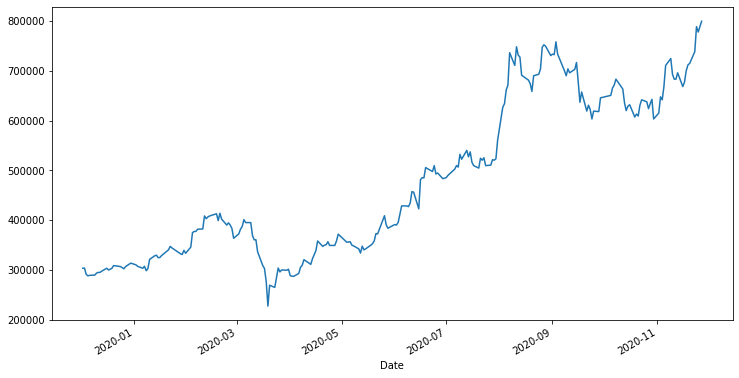

In [ ]:
# LG 화학 주가 데이터 시각화
import matplotlib.pyplot as plt

df['LG_chem'].plot(figsize=(12.2,6.4))

In [ ]:
# ADF 안정성 테스트
# ADF test: 시계열이 안정적(Stationary)인지 여부를 확인하는데 이용하는 것
# Null hypothesis: 기각에 실패하면 시계열이 안정적이지 않음을 의미
# Alternative hypothesis: 귀무 가설(null hypothesis)이 기각되고 시계열이 안정적이다.

n_obs=20
df_train, df_test=df[0:-n_obs], df[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result=adfuller(df.values)
    print('ADF Statistics: %f' %result[0])
    print('Critical values: ')
    for key, values in result[4].items():
        print('\t%s: %.3f'%(key, values))

print('ADF test: Tesla time series')
adf_test(df_train['TSLA'])
print('ADF Test: Lithium Americas time Series')
adf_test(df_train['LAC'])
print('ADF Test: LG chem time series')
adf_test(df_train['LG_chem'])

ADF test: Tesla time series
ADF Statistics: -0.427168
Critical values: 
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Test: Lithium Americas time Series
ADF Statistics: -0.511177
Critical values: 
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Test: LG chem time series
ADF Statistics: -0.861097
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574


In [ ]:
# KPSSS: 시계열이 평균 또는 선형 추세 주변에 고정되어 있는지 또는 단위 루트(unit root)로 인해 고정되지 않았는지?
# 이걸 확인하는 것.

# Null hypothesis: 시계열이 안정적이지 않음
# Alternative hypothesis: 시계열이 안정적

from statsmodels.tsa.stattools import kpss 

def kpss_test(df):
    statistics, p_value, n_lags, critical_values = kpss(df.values)

    print(f'KPSS statistics: {statistics}')
    print(f'p-values: {p_value}')
    print(f'num lags: {n_lags}')
    for key, value in critical_values.items():
        print(f' {key}:{value}')
print('KPSS test: Tesla time seriesa')
kpss_test(df_train['TSLA'])
print('KPSS Test: Lithium Americas time series')
kpss_test(df_train['LAC'])
print('KPSS Test: LG Chem time series')
kpss_test(df_train['LG_chem'])

KPSS test: Tesla time seriesa
KPSS statistics: 1.306741662326901
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: Lithium Americas time series
KPSS statistics: 1.0297346563838206
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: LG Chem time series
KPSS statistics: 1.225284570307073
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739


In [ ]:
#ADF 하고 KPSS 시계열을 모두 사용하였는데 안정하지 않다는 것을 암.
# 차분(또는 비율로) 시계열을 변환시켜 안정적으로 만들어야함.

# 일일 수익률(=변화율)로 변환하기 -> 두 개의 연속된 시계열 값의 차분(diffence)을 취하는 방법 -> 가장 많이 쓰는 방법
# 주식 데이터에서는 차분 값보다는 수익률이 더욱 이해하기가 쉽기 때문에 일일변화율을 계산하여 시계열 데이터를 적용.

# 일일 주가 변화율 계산
for col in df.columns:
    df['r_'+col]=100*df[col].pct_change()
    #pct_change(percent change)
df.dropna(inplace=True)
print(df.head())

                 TSLA       LG_chem   LAC    r_TSLA  r_LG_chem     r_LAC
Date                                                                    
2019-12-03  67.239998  303712.71875  2.88  0.397167   0.161804  0.348440
2019-12-04  66.606003  290955.84375  2.91 -0.942884  -4.200310  1.041666
2019-12-05  66.073997  288011.93750  2.94 -0.798735  -1.011805  1.030927
2019-12-06  67.178001  288993.21875  2.98  1.670860   0.340709  1.360543
2019-12-09  67.905998  289483.87500  3.03  1.083683   0.169781  1.677851


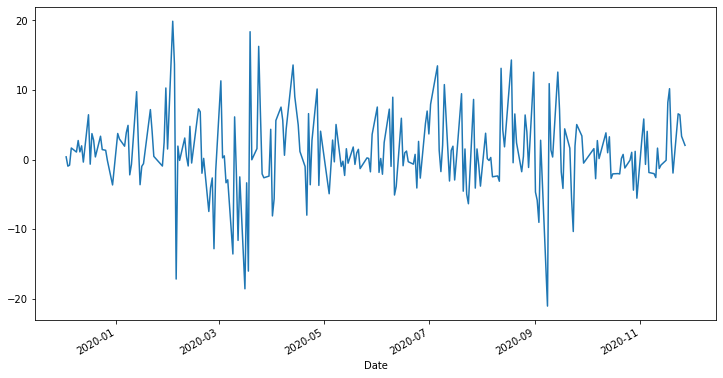

In [ ]:
plt.show(df['r_TSLA'].plot(figsize=(12.2,6.4)))

In [ ]:
# 차분해서 넣기
n_obs=20
df_train, df_test=df[0:-n_obs], df[-n_obs:]

print('ADF test: Tesla time series')
adf_test(df_train['TSLA'])
print('ADF Test: Lithium Americas time Series')
adf_test(df_train['LAC'])
print('ADF Test: LG chem time series')
adf_test(df_train['LG_chem'])

ADF test: Tesla time series
ADF Statistics: -0.427168
Critical values: 
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Test: Lithium Americas time Series
ADF Statistics: -0.511177
Critical values: 
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Test: LG chem time series
ADF Statistics: -0.861097
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574


In [ ]:
print('KPSS test: Tesla time seriesa')
kpss_test(df_train['r_TSLA'])
print('KPSS Test: Lithium Americas time series')
kpss_test(df_train['r_LAC'])
print('KPSS Test: LG Chem time series')
kpss_test(df_train['r_LG_chem'])

KPSS test: Tesla time seriesa
KPSS statistics: 0.06332825248962899
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: Lithium Americas time series
KPSS statistics: 0.10728296903518375
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: LG Chem time series
KPSS statistics: 0.0827618633323416
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


시계열 분석 20210625
--

시계열 안정성 테스트 - ADF(augmneated Cikey - Fuller)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
!pip install yfinance

In [ ]:
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')


# 테슬라
df_tsla=yf.download('TSLA', start='2019-12-01', end='2020-11-30')

# LG화학
df_lg=yf.download('051910.KS', start='2019-12-01', end='2020-11-30')

#리튬아메리카
df_lac=yf.download('LAC', start='2019-12-01', end='2020-11-30')

# GameStop
df_game=yf.download('GME', start='2020-12-01', end='2021-05-31')

#각 종목의 증가 데이터만 모아서 하나의 테이블을 합치기
df=pd.merge(df_tsla['Adj Close'], df_lg['Adj Close'], left_index=True, right_index=True, how='left').rename(columns={'Adj Close_x': 'TSLA', 'Adj Close_y':'LG_chem'})

df=pd.merge(df, df_lac['Adj Close'], left_index=True, right_index=True, how='left').rename(columns={'Adj Close':'LAC'})

df.dropna(inplace=True)
print(df.head)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
<bound method NDFrame.head of                   TSLA       LG_chem    LAC
Date                                       
2019-12-02   66.973999  303222.09375   2.87
2019-12-03   67.239998  303712.71875   2.88
2019-12-04   66.606003  290955.84375   2.91
2019-12-05   66.073997  288011.93750   2.94
2019-12-06   67.178001  288993.21875   2.98
...                ...           ...    ...
2020-11-20  489.609985  715105.68750  10.34
2020-11-23  521.849976  738810.81250  10.40
2020-11-24  555.380005  789184.31250  10.65
2020-11-25  574.000000  778319.43750  11.06
2020-11-27  585.760010  800049.12500  11.52

[239 rows x 3 columns]>


In [ ]:
df_game['GME']=df_game['Adj Close']

In [ ]:
gme=df_game['GME']

In [ ]:
df_game=pd.DataFrame(gme, index=df_game.index, columns=['GME'])

In [ ]:
df.head()

,TSLA,LG_chem,LAC
Date,,,
2019-12-02,66.973999,303222.09375,2.87
2019-12-03,67.239998,303712.71875,2.88
2019-12-04,66.606003,290955.84375,2.91
2019-12-05,66.073997,288011.93750,2.94
2019-12-06,67.178001,288993.21875,2.98


In [ ]:
df_game.head()

,GME
Date,
2020-12-01,15.800000
2020-12-02,16.580000
2020-12-03,16.120001
2020-12-04,16.900000
2020-12-07,16.350000


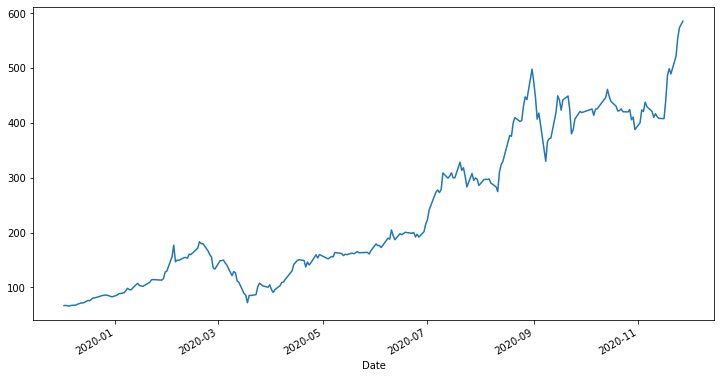

In [ ]:
plt.show(df['TSLA'].plot(figsize=(12.2,6.4)))

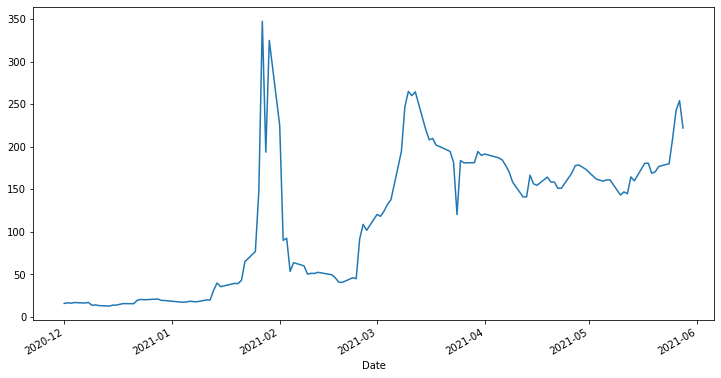

In [ ]:
plt.show(df_game['GME'].plot(figsize=(12.2,6.4)))

ADF test: 시계열이 안정적(stationary)인지 여부를 확인하는데 이용하는 것
--

Null hypothesis(귀무가설): 기각에 실패하면 시계열이 안정적이 않음을 의미

Alternative hypothesis(대립가설): 귀무 가설이 기각되고 시계열이 안정적임을 의미

In [ ]:
# ADF 안정성 테스트
# ADF test: 시계열이 안정적(Stationary)인지 여부를 확인하는데 이용하는 것
# Null hypothesis: 기각에 실패하면 시계열이 안정적이지 않음을 의미
# Alternative hypothesis: 귀무 가설(null hypothesis)이 기각되고 시계열이 안정적이다.

n_obs=20
df_train, df_test=df[0:-n_obs], df[-n_obs:]
df_game_train, df_game_test=df_game[0:-n_obs], df_game[-n_obs:]

from statsmodels.tsa.stattools import adfuller

def adf_test(df):
    result=adfuller(df.values)
    print('ADF Statistics: %f' %result[0])
    print('Critical values: ')
    for key, values in result[4].items():
        print('\t%s: %.3f'%(key, values))

print('ADF test: Tesla time series')
adf_test(df_train['TSLA'])
print('ADF Test: Lithium Americas time Series')
adf_test(df_train['LAC'])
print('ADF Test: LG chem time series')
adf_test(df_train['LG_chem'])


print('ADF Test: GME time series')
adf_test(df_game_train['GME'])

ADF test: Tesla time series
ADF Statistics: -0.427168
Critical values: 
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Test: Lithium Americas time Series
ADF Statistics: -0.511177
Critical values: 
	1%: -3.462
	5%: -2.875
	10%: -2.574
ADF Test: LG chem time series
ADF Statistics: -0.861097
Critical values: 
	1%: -3.461
	5%: -2.875
	10%: -2.574
ADF Test: GME time series
ADF Statistics: -1.711054
Critical values: 
	1%: -3.500
	5%: -2.892
	10%: -2.583


P-value > 0.05이므로 귀무 가설을 기각할 수 없음. 세 개의 시계열은 안정적이지 않다.

KPSS: 시계열이 평균 또는 선형 추세 주변에 고정되어 있는지? 또는 단위 루트(unit root)로 인해 고정되지 않았는지? 를 확인하는 것 
--

Null hypothesis: 시계열이 안정적

Alternative hypothesis: 시계열이 안정적이지 않다.

In [ ]:
# KPSSS: 시계열이 평균 또는 선형 추세 주변에 고정되어 있는지 또는 단위 루트(unit root)로 인해 고정되지 않았는지?
# 이걸 확인하는 것.

# Null hypothesis: 시계열이 안정적이지 않음
# Alternative hypothesis: 시계열이 안정적

from statsmodels.tsa.stattools import kpss 

def kpss_test(df):
    statistics, p_value, n_lags, critical_values = kpss(df.values)

    print(f'KPSS statistics: {statistics}')
    print(f'p-values: {p_value}')
    print(f'num lags: {n_lags}')
    for key, value in critical_values.items():
        print(f' {key}:{value}')
print('KPSS test: Tesla time seriesa')
kpss_test(df_train['TSLA'])
print('KPSS Test: Lithium Americas time series')
kpss_test(df_train['LAC'])
print('KPSS Test: LG Chem time series')
kpss_test(df_train['LG_chem'])
print('KPSS Test: GME time series')
kpss_test(df_game_train['GME'])

KPSS test: Tesla time seriesa
KPSS statistics: 1.3117819382548639
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: Lithium Americas time series
KPSS statistics: 1.0334501601687882
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: LG Chem time series
KPSS statistics: 1.229477385125233
p-values: 0.01
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: GME time series
KPSS statistics: 0.6561268823805283
p-values: 0.017533919783588335
num lags: 13
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739


p-value < 0.05 이므로 귀무 가설을 기각하며, 세 개의 시계열은 안정적이지 않음을 알 수 있다.

ADF하고 KPSS 시계열을 모두 사용을 하였는데 안정하지 않다는 것을 암.

차분 (또는 비율로) 시계열 열을 변환시켜야함 -> 안정적으로 만들어야 함.

일일 수익률(=변화율)로 변환하기 -> 두 개의 연속된 시계열 값의 차분(diffence)를 취하는 방법 -> 가장 많이 쓰이는 방법

주식 데이터는 차분값보다는 수익률로 더욱 이해하기 쉽기 때문에 일일변화율을 계산하여 시계열 데이터를 적용.

In [ ]:
# 일일 주가 변화율 계산.

for col in df.columns:
    df['r_'+col]=100*df[col].pct_change()
    #pct_change: percentage change
df.dropna(inplace=True)
df.head()

,TSLA,LG_chem,LAC,r_TSLA,r_LG_chem,r_LAC
Date,,,,,,
2019-12-03,67.239998,303712.71875,2.88,0.397167,0.161804,0.348440
2019-12-04,66.606003,290955.84375,2.91,-0.942884,-4.200310,1.041666
2019-12-05,66.073997,288011.93750,2.94,-0.798735,-1.011805,1.030927
2019-12-06,67.178001,288993.21875,2.98,1.670860,0.340709,1.360543
2019-12-09,67.905998,289483.87500,3.03,1.083683,0.169781,1.677851


In [ ]:
for col in df_game.columns:
    df_game['r_'+col]=100*df_game[col].pct_change()
    #pct_change: percentage change
df_game.dropna(inplace=True)
df_game.head()

,GME,r_GME
Date,,
2020-12-02,16.580000,4.936707
2020-12-03,16.120001,-2.774422
2020-12-04,16.900000,4.838702
2020-12-07,16.350000,-3.254433
2020-12-08,16.940001,3.608564


일일 수익률(=주가 변화율) 시각화 하기

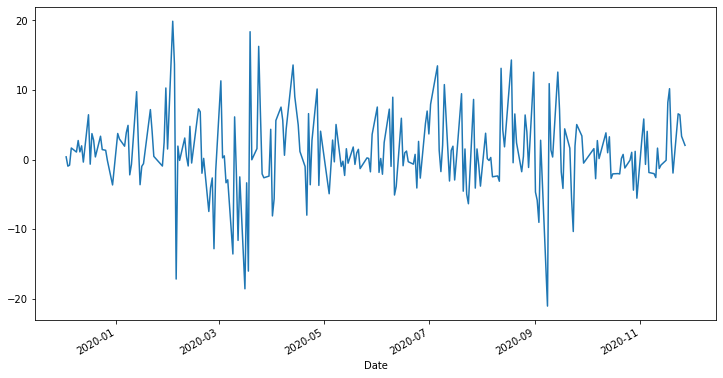

In [ ]:
plt.show(df['r_TSLA'].plot(figsize=(12.2,6.4)))

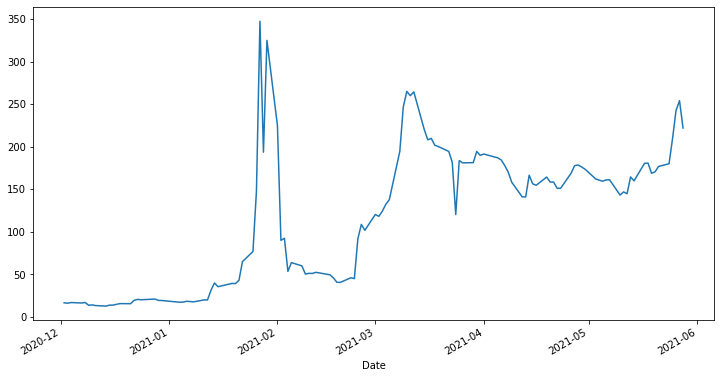

In [ ]:
plt.show(df_game['GME'].plot(figsize=(12.2,6.4)))

In [ ]:
print('ADF test: Tesla time series')
adf_test(df['r_TSLA'])
print('ADF Test: Lithium Americas time Series')
adf_test(df['r_LAC'])
print('ADF Test: LG chem time series')
adf_test(df['r_LG_chem'])


print('ADF Test: GME time series')
adf_test(df_game['r_GME'])

ADF test: Tesla time series
ADF Statistics: -15.006079
Critical values: 
	1%: -3.458
	5%: -2.874
	10%: -2.573
ADF Test: Lithium Americas time Series
ADF Statistics: -8.281278
Critical values: 
	1%: -3.459
	5%: -2.874
	10%: -2.573
ADF Test: LG chem time series
ADF Statistics: -7.524288
Critical values: 
	1%: -3.458
	5%: -2.874
	10%: -2.573
ADF Test: GME time series
ADF Statistics: -5.876200
Critical values: 
	1%: -3.487
	5%: -2.886
	10%: -2.580


In [ ]:
print('KPSS test: Tesla time seriesa')
kpss_test(df['r_TSLA'])
print('KPSS Test: Lithium Americas time series')
kpss_test(df['r_LAC'])
print('KPSS Test: LG Chem time series')
kpss_test(df['r_LG_chem'])
print('KPSS Test: GME time series')
kpss_test(df_game['r_GME'])

KPSS test: Tesla time seriesa
KPSS statistics: 0.042268648725171505
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: Lithium Americas time series
KPSS statistics: 0.09658678606911716
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: LG Chem time series
KPSS statistics: 0.08277404897388178
p-values: 0.1
num lags: 15
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739
KPSS Test: GME time series
KPSS statistics: 0.14474191835191674
p-values: 0.1
num lags: 13
 10%:0.347
 5%:0.463
 2.5%:0.574
 1%:0.739


Error Analysis
--

In [ ]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

def stationary_adf_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4], 
                                   index=['Test Statistics','p-value','Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data)[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                       index=['Test Statistics','p-value','Used Lag','Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf


def stationary_kpss_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3], 
                                   index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                       index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss
                                

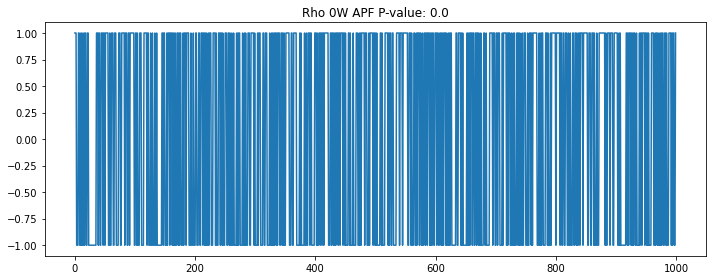

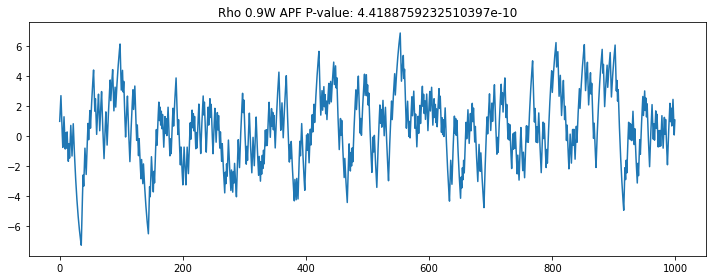

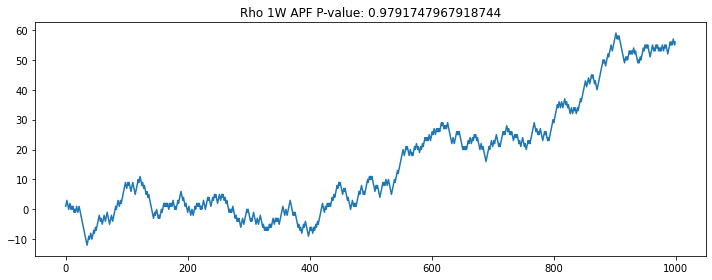

In [ ]:
from random import seed, random
import matplotlib.pyplot as plt
import numpy as np


# 랜덤워크 데이터 생성 및 통계량 Test (rho=0)
plt.figure(figsize=(10,4))
seed(1)
rho=0 
random_walk=[-1 if random()>0.5 else 1]

for i in range(1, 1000):
    movement=-1 if random()<0.5 else 1 #list가 아닌 value값으로 붙히고 싶어서
    value= rho*random_walk[i-1]+movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho {}W APF P-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

# 랜덤워크 데이터 생성 및 통계량 Test (rho=0.9)
plt.figure(figsize=(10,4))
seed(1)
rho=0.9
random_walk=[-1 if random()>0.5 else 1]

for i in range(1, 1000):
    movement=-1 if random()<0.5 else 1 #list가 아닌 value값으로 붙히고 싶어서
    value= rho*random_walk[i-1]+movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho {}W APF P-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

# 랜덤워크 데이터 생성 및 통계량 Test (rho=1)
plt.figure(figsize=(10,4))
seed(1)
rho=1
random_walk=[-1 if random()>0.5 else 1]

for i in range(1, 1000):
    movement=-1 if random()<0.5 else 1 #list가 아닌 value값으로 붙히고 싶어서
    value= rho*random_walk[i-1]+movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho {}W APF P-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

- 계수가 1(rho=1)에 가까울수록 원래 차트와 유사해짐

시계열 알고리즘
---

비대칭(Skewed) 데이터를 처리하는 방법
--

House Prices 

https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [ ]:
from google.colab import files 
files.upload()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler

df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')
df_sub=pd.read_csv('sample_submission.csv')

In [ ]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [ ]:
df_sub.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977


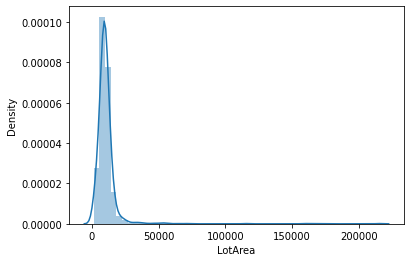

In [ ]:
#skewness 확인
df_train['LotArea'].skew()

# KDE plot 확인
sns.distplot(df_train['LotArea']) #displot 찍으면 선 사라짐

## log Transform

- Skewness를 제거하기 위해 가장 간단한 방법

In [ ]:
# 값들을 확인
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


-0.1379938086958118


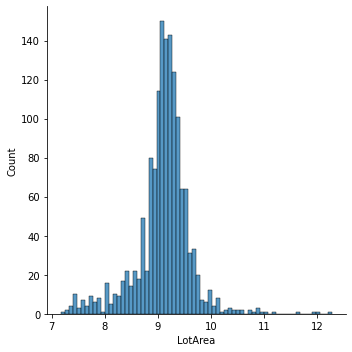

In [ ]:
#로그 변환
df_log=np.log(df_train['LotArea'])

#skewness 확인
print(df_log.skew())

# KDE plot 출력
sns.displot(df_log)

## Square Root Transform / 루트(제곱근) 변환

- 루트 변환

In [ ]:
#루트 변환
df_root=np.sqrt(df_train['LotArea'])/len(df_train['LotArea'])

4.139713548289235


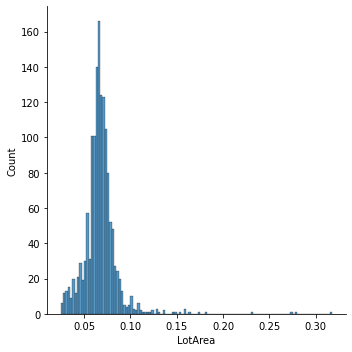

In [ ]:
#skewness 확인
print(df_root.skew())
#KDE plot 출력
sns.displot(df_root)

## Box-cox transform

- 변환 목적

1) 정규분포가 아닌 자료를 정규분포로 변환하기 위해서 사용

2) 연속형 측정자료의 형태를 파악

3) 추후 통계분석에 대한 정규분포 가정을 검정.

0.026686965055625272


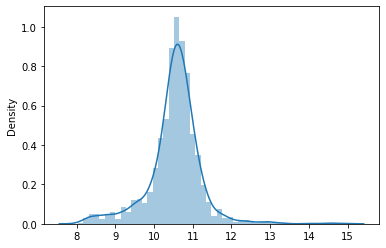

In [ ]:
from scipy.stats import boxcox

# box-cos 변환
df_boxcos=pd.Series(boxcox(df_train['LotArea'])[0])

#skewness 확인
print(df_boxcos.skew())

# KDE plot 출력
sns.distplot(df_boxcos)

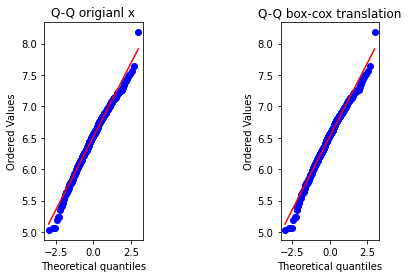

최적의 람다값 2.399178840216162


In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

#그림판 준비
fig = plt.figure()
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(133)

#log gamma continuous random variable 생성
x = stats.loggamma.rvs(5,size = 500) +5
# Q-Q plot 그리긔
prob = stats.probplot(x, dist = stats.norm, plot = ax1)
ax1.set_title('Q-Q origianl x')

# box-cox 변환 사용
x_trans, optimal_labmda = stats.boxcox(x)
prob = stats.probplot(x, dist = stats.norm, plot = ax2)
ax2.set_title('Q-Q box-cox translation')
plt.show()

# box-cox 최적의 람다값 찾기
print('최적의 람다값', optimal_labmda)

### 정상성 테스트 방향

> **추세와 계절성 모두 제거된 정상성 데이터 변환 필요!**
>> - **ADF 정상성 확인 -> 추세 제거 확인 Measure**  
: ADF 검정통계량은 정상이라고 해도 데이터에 계절성이 포함되면 ACF의 비정상 Lag 존재하는 비정상데이터 가능  

>> - **KPSS 정상성 확인 -> 계절성 제거 확인 Measure**  
: KPSS 검정통계량은 정상이라고 해도 데이터에 추세가 포함되면 ACF의 비정상 Lag 존재하는 비정상데이터 가능 

In [ ]:
# error analysis

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

def stationary_adf_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4], 
                                   index=['Test Statistics','p-value','Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data)[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                       index=['Test Statistics','p-value','Used Lag','Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf


def stationary_kpss_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3], 
                                   index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                       index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

In [ ]:
# 라이브러리 및 데이터 로딩
import pandas as pd
from statsmodels import datasets
import matplotlib.pyplot as plt
import statsmodels.api as sm

raw_set =datasets.get_rdataset('deaths', package='MASS')
raw=raw_set.data
raw

,time,value
0,1974.000000,3035
1,1974.083333,2552
2,1974.166667,2704
3,1974.250000,2554
4,1974.333333,2014
...,...,...
67,1979.583333,1354
68,1979.666667,1333
69,1979.750000,1492
70,1979.833333,1781


In [ ]:
raw_set.keys()

dict_keys(['data', '__doc__', 'package', 'title', 'from_cache', 'raw_data'])

In [ ]:
# 시간변수 추출

raw.time=pd.date_range('1974-01-01', periods=len(raw), freq='M')
raw['month']=raw.time.dt.month
raw

,time,value,month
0,1974-01-31,3035,1
1,1974-02-28,2552,2
2,1974-03-31,2704,3
3,1974-04-30,2554,4
4,1974-05-31,2014,5
...,...,...,...
67,1979-08-31,1354,8
68,1979-09-30,1333,9
69,1979-10-31,1492,10
70,1979-11-30,1781,11


In [ ]:
#데이터 확인 및 추세 추정
display(raw.tail())

,time,value,month
67,1979-08-31,1354,8
68,1979-09-30,1333,9
69,1979-10-31,1492,10
70,1979-11-30,1781,11
71,1979-12-31,1915,12


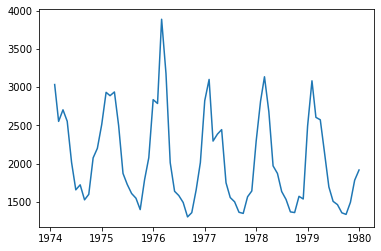

In [ ]:
# 데이터 확인 및 추세 추정
# display(raw.tail())
plt.plot(raw.time, raw.value)
plt.show()

,Stationarity_adf
Test Statistics,-0.568650
p-value,0.877910
Used Lag,12.000000
Used Observations,59.000000
Critical Value(1%),-3.546395
Maximum information Criteria,841.377559


,Stationarity_kpss
Test Statistics,0.651989
p-value,0.017910
Used Lag,12.000000
Critical Value(10%),0.347000


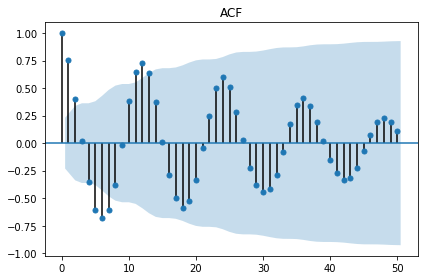

In [ ]:
display(stationary_adf_test(raw.value, []))
display(stationary_kpss_test(raw.value, []))
sm.graphics.tsa.plot_acf(raw.value, lags=50, use_vlines=True, title='ACF')
plt.tight_layout()
plt.show()

In [ ]:
# c(month): 더미화 작업 / -1 절편을 제거
# constant_x를 따로 취해주지 않았기 때문에 여기서 C(month)에서 하나를 빼줌으로써
# y=b0+b1x1+b2x2에서 b0을 뛰고 x1부터 시작할 수 있게 해준다.
result=sm.OLS.from_formula(formula='value ~ C(month)-1',data=raw).fit()
display(result.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  value   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     31.66
Date:                Fri, 25 Jun 2021   Prob (F-statistic):           6.55e-21
Time:                        06:34:33   Log-Likelihood:                -494.38
No. Observations:                  72   AIC:                             1013.
Df Residuals:                      60   BIC:                             1040.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
C(month)[1]   2959.3333    103.831     28.502      0.000    2751.641    3167.025
C(month)[2]   2894.6667    103.831     27.879      0.000    2686.975    3102.359
C(month)[3]   2743.0000    103.831     26.418      0.000    2535.308    2950.692
C(month)[4]   2269.6667    103.831     21.859      0.000    2061.975    2477.359
C(month)[5]   1805.1667    103.831     17.386      0.000    1597.475    2012.859
C(month)[6]   1608.6667    103.831     15.493      0.000    1400.975    1816.359
C(month)[7]   1550.8333    103.831     14.936      0.000    1343.141    1758.525
C(month)[8]   1408.3333    103.831     13.564      0.000    1200.641    1616.025
C(month)[9]   1397.3333    103.831     13.458      0.000    1189.641    1605.025
C(month)[10]  1690.0000    103.831     16.277      0.000    1482.308    1897.692
C(month)[11]  1874.0000    103.831     18.049      0.000    1666.308    2081.692
C(month)[12]  2478.5000    103.831     23.871      0.000    2270.808    2686.192
==============================================================================
Omnibus:                       19.630   Durbin-Watson:                   1.374
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.630
Skew:                           0.787   Prob(JB):                     1.67e-11
Kurtosis:                       6.750   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

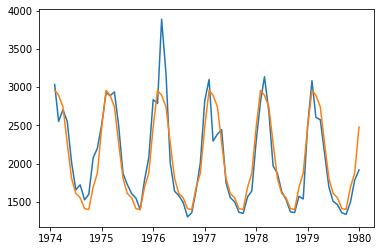

In [ ]:
# fittedvalues: 판별함수 z=w^T X: 실제 fitting값.

plt.plot(raw.time, raw.value, raw.time, result.fittedvalues)
plt.show()

,Stationarity_adf
Test Statistics,-5.842931e+00
p-value,3.740637e-07
Used Lag,0.000000e+00
Used Observations,7.100000e+01
Critical Value(1%),-3.526005e+00
Maximum information Criteria,8.123641e+02


,Stationarity_kpss
Test Statistics,0.538249
p-value,0.033052
Used Lag,12.000000
Critical Value(10%),0.347000


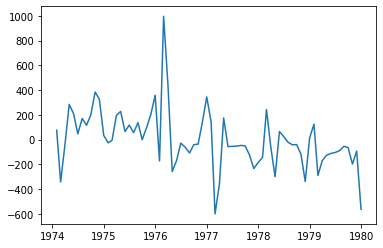

In [ ]:
# 추세 제거 및 정상성 확인
# resid: 잔차
plt.plot(raw.time, result.resid)

display(stationary_adf_test(result.resid, []))
display(stationary_kpss_test(result.resid, []))

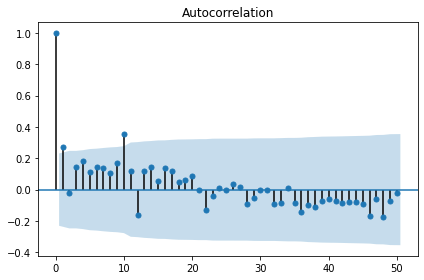

In [ ]:
sm.graphics.tsa.plot_acf(result.resid, lags=50, use_vlines=True)
plt.tight_layout()
plt.show()

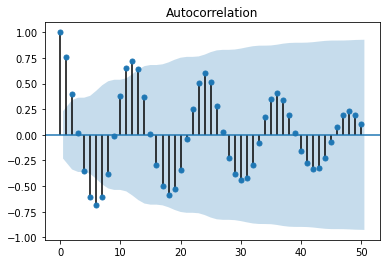

In [ ]:
# 계절성 제거 및 정상성 확인
# 방법2

sm.graphics.tsa.plot_acf(raw.value, lags=50, use_vlines=True)
plt.show()

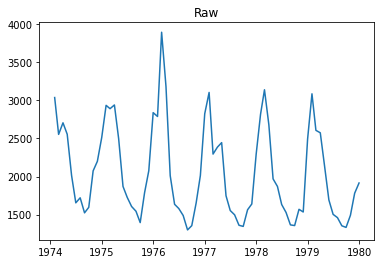

In [ ]:
plt.plot(raw.time, raw.value)
plt.title('Raw')
plt.show()

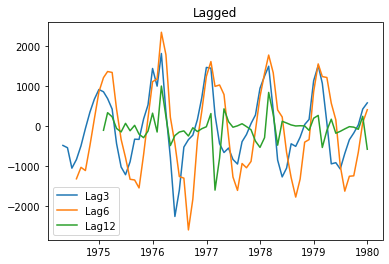

In [ ]:
seasonal_lag = 3
plt.plot(raw.time[seasonal_lag:], raw.value.diff(seasonal_lag).dropna(), label='Lag{}'.format(seasonal_lag))
seasonal_lag = 6
plt.plot(raw.time[seasonal_lag:], raw.value.diff(seasonal_lag).dropna(), label='Lag{}'.format(seasonal_lag))
seasonal_lag = 12
plt.plot(raw.time[seasonal_lag:], raw.value.diff(seasonal_lag).dropna(), label='Lag{}'.format(seasonal_lag))
plt.title('Lagged')
plt.legend()
plt.show()

,Stationarity_adf
Test Statistics,-5.572673
p-value,0.000001
Used Lag,10.000000
Used Observations,58.000000
Critical Value(1%),-3.548494
Maximum information Criteria,826.272024


,Stationarity_kpss
Test Statistics,0.362944
p-value,0.093128
Used Lag,11.000000
Critical Value(10%),0.347000


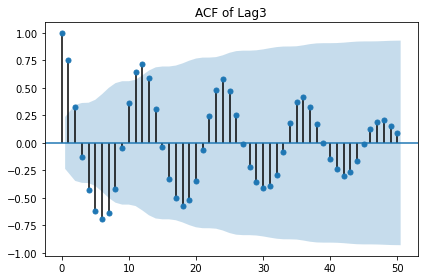

In [ ]:
seasonal_lag = 3
display(stationary_adf_test(raw.value.diff(seasonal_lag).dropna(), []))
display(stationary_kpss_test(raw.value.diff(seasonal_lag).dropna(), []))
sm.graphics.tsa.plot_acf(raw.value.diff(seasonal_lag).dropna(), lags=50, 
                         use_vlines=True, title='ACF of Lag{}'.format(seasonal_lag))
plt.tight_layout()
plt.show()

,Stationarity_adf
Test Statistics,-4.299976
p-value,0.000444
Used Lag,11.000000
Used Observations,54.000000
Critical Value(1%),-3.557709
Maximum information Criteria,786.671043


,Stationarity_kpss
Test Statistics,0.349646
p-value,0.098859
Used Lag,11.000000
Critical Value(10%),0.347000


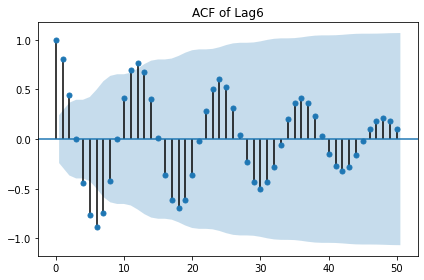

In [ ]:
# seasonal_lag는 6이 딱 좋다!

seasonal_lag = 6
display(stationary_adf_test(raw.value.diff(seasonal_lag).dropna(), []))
display(stationary_kpss_test(raw.value.diff(seasonal_lag).dropna(), []))
sm.graphics.tsa.plot_acf(raw.value.diff(seasonal_lag).dropna(), lags=50, 
                         use_vlines=True, title='ACF of Lag{}'.format(seasonal_lag))
plt.tight_layout()
plt.show()

,Stationarity_adf
Test Statistics,-2.137208
p-value,0.229819
Used Lag,11.000000
Used Observations,48.000000
Critical Value(1%),-3.574589
Maximum information Criteria,703.717969


,Stationarity_kpss
Test Statistics,0.09452
p-value,0.10000
Used Lag,11.00000
Critical Value(10%),0.34700


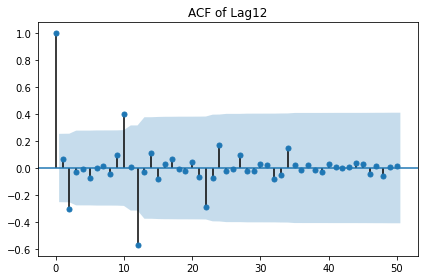

In [ ]:
seasonal_lag = 12
display(stationary_adf_test(raw.value.diff(seasonal_lag).dropna(), []))
display(stationary_kpss_test(raw.value.diff(seasonal_lag).dropna(), []))
sm.graphics.tsa.plot_acf(raw.value.diff(seasonal_lag).dropna(), lags=50, 
                         use_vlines=True, title='ACF of Lag{}'.format(seasonal_lag))
plt.tight_layout()
plt.show()

20210628 수업
--

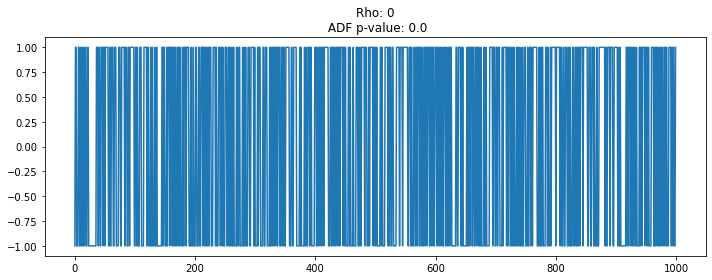

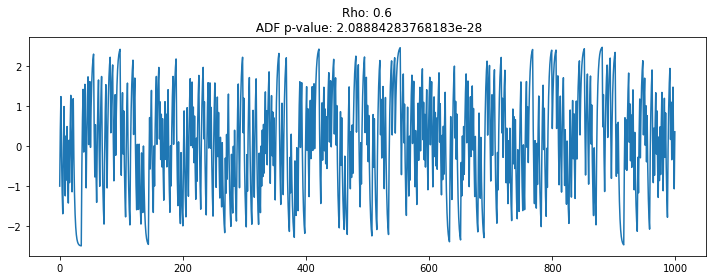

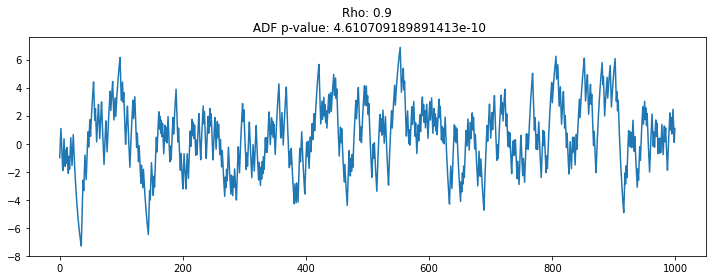

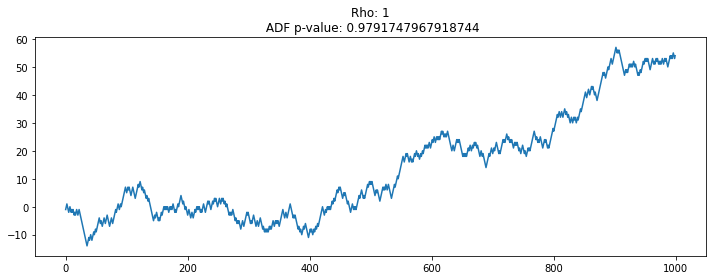

In [ ]:
# 라이브러리 호출
import pandas as pd
import numpy as np
import statsmodels.api as sm
from random import seed, random
import matplotlib.pyplot as plt

# 랜덤워크 데이터 생성 및 통계량 Test (rho=0)
plt.figure(figsize=(10, 4))
seed(1)
rho = 0
random_walk = [-1 if random() < 0.5 else 1]
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = rho * random_walk[i-1] + movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho: {}\n ADF p-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

# 랜덤워크 데이터 생성 및 통계량 Test (rho=0.6)
plt.figure(figsize=(10, 4))
seed(1)
rho = 0.6
random_walk = [-1 if random() < 0.5 else 1]
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = rho * random_walk[i-1] + movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho: {}\n ADF p-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

# 랜덤워크 데이터 생성 및 통계량 Test (rho=0.9)
plt.figure(figsize=(10, 4))
seed(1)
rho = 0.9
random_walk = [-1 if random() < 0.5 else 1]
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = rho * random_walk[i-1] + movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho: {}\n ADF p-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

# 랜덤워크 데이터 생성 및 통계량 Test (rho=1)
plt.figure(figsize=(10, 4))
seed(1)
rho = 1
random_walk = [-1 if random() < 0.5 else 1]
for i in range(1, 1000):
    movement = -1 if random() < 0.5 else 1
    value = rho * random_walk[i-1] + movement
    random_walk.append(value)
plt.plot(random_walk)
plt.title('Rho: {}\n ADF p-value: {}'.format(rho, np.ravel(stationary_adf_test(random_walk, []))[1]))
plt.tight_layout()
plt.show()

- 랜덤워크 데이터가 안정적이지 않음을 명시하고 있음.


실습: 항공사 승객수요 스케일 변환 (Log/Box-cox)
--

In [ ]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy as sp

# 데이터 준비
data=sm.datasets.get_rdataset('AirPassengers')
raw=data.data.copy()

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
raw

,time,value
0,1949.000000,112
1,1949.083333,118
2,1949.166667,132
3,1949.250000,129
4,1949.333333,121
...,...,...
139,1960.583333,606
140,1960.666667,508
141,1960.750000,461
142,1960.833333,390


In [ ]:
# box-cos 변환 모수 추정
# 정규분포의 특정 범위 (x)에서 lambda를 바꿔가며 정규성(measure: y)이 가장 높은 lambda(l_opt)를 선정
x,y=sp.stats.boxcox_normplot(raw.value, la=-3, lb=3) # la, lb는 스칼라 위에서 아래까지의 범위 -3, 3은 포함되지 않음
y_transfor, l_opt=sp.stats.boxcox(raw.value)
print('Optimal Lambda :', l_opt)

Optimal Lambda : 0.14802265137037945


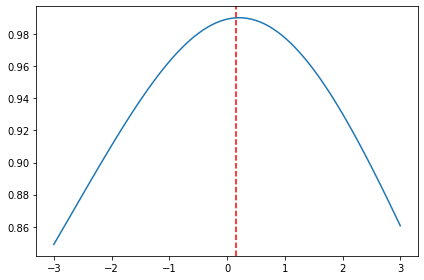

In [ ]:
plt.plot(x,y)
plt.axvline(x=l_opt, color='r', ls='--')
plt.tight_layout()
plt.show()

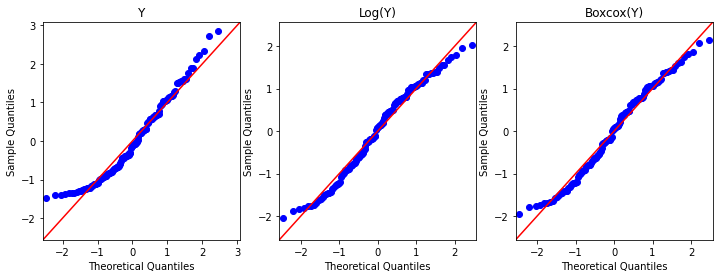

In [ ]:
plt.figure(figsize=(12,4))
sm.qqplot(raw.value, fit=True, line='45', ax=plt.subplot(131))
plt.title('Y')
sm.qqplot(np.log(raw.value), fit=True, line='45', ax=plt.subplot(132))
plt.title('Log(Y)')
sm.qqplot(y_transfor, fit=True, line='45', ax=plt.subplot(133))
plt.title('Boxcox(Y)')
plt.show()

실습: 항공사 승객수요 정상성 변환
--

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 데이터 준비
data=sm.datasets.get_rdataset('AirPassengers')
raw=data.data.copy()

#데이터 전처리
# 시간 인덱싱

if 'time' in raw.columns:
    raw.index=pd.date_range(start='1/1/1949', periods=len(raw['time']), freq='M')
    del raw['time']

In [ ]:
# error analysis

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

def stationary_adf_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4], 
                                   index=['Test Statistics','p-value','Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data)[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf=pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                       index=['Test Statistics','p-value','Used Lag','Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items(): #[4]는 유의수준을 의미한다.
            Stationarity_adf['Critical Value(%s)'%key]=value
            Stationarity_adf['Maximum information Criteria']=sm.tsa.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf=pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf


def stationary_kpss_test(Y_Data, Target_name):
    if len(Target_name)==0:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3], 
                                   index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss=pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                       index=['Test Statistics','p-value','Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items(): #[4]는 유의수준을 의미한다.
            Stationarity_kpss['Critical Value(%s)'%key]=value
            Stationarity_kpss=pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

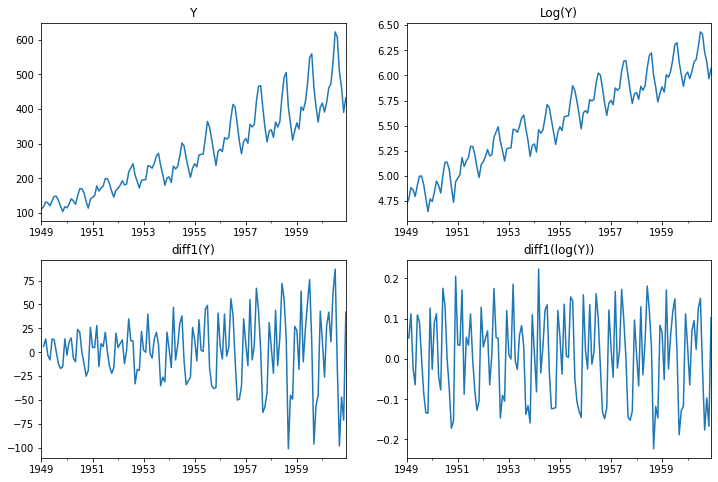

In [ ]:
# 정상성 확보
plt.figure(figsize=(12,8))
raw.plot(ax=plt.subplot(221), title='Y', legend=False)
np.log(raw).plot(ax=plt.subplot(222), title='Log(Y)', legend=False)
raw.diff(1).plot(ax=plt.subplot(223), title='diff1(Y)', legend=False)
np.log(raw).diff(1).plot(ax=plt.subplot(224), title='diff1(log(Y))', legend=False)
plt.show()

'Non-transfer'

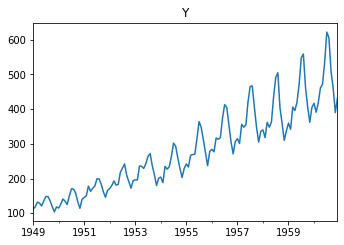

,Stationarity_adf
Test Statistics,0.815369
p-value,0.991880
Used Lag,13.000000
Used Observations,130.000000
Critical Value(1%),-3.481682
Maximum information Criteria,996.692931


,Stationarity_kpss
Test Statistics,1.052175
p-value,0.010000
Used Lag,14.000000
Critical Value(10%),0.347000


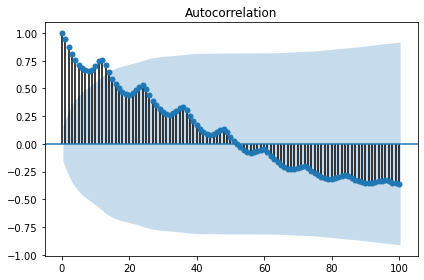

In [ ]:
# 정상성 테스트
# 미변환
display('Non-transfer')
plt.figure(figsize=(12,8))
raw.plot(ax=plt.subplot(222), title='Y', legend=False)
plt.show()

candidate_none=raw.copy()
display(stationary_adf_test(candidate_none.values.flatten(), []))
display(stationary_kpss_test(candidate_none.values.flatten(), []))
sm.graphics.tsa.plot_acf(candidate_none, lags=100, use_vlines=True)
plt.tight_layout()
plt.show()

'Log transfer:'

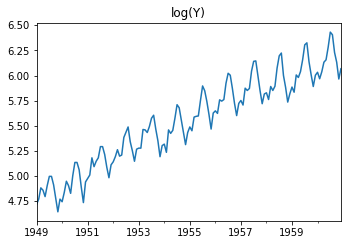

,Stationarity_adf
Test Statistics,-1.717017
p-value,0.422367
Used Lag,13.000000
Used Observations,130.000000
Critical Value(1%),-3.481682
Maximum information Criteria,-445.399031


,Stationarity_kpss
Test Statistics,1.053981
p-value,0.010000
Used Lag,14.000000
Critical Value(10%),0.347000


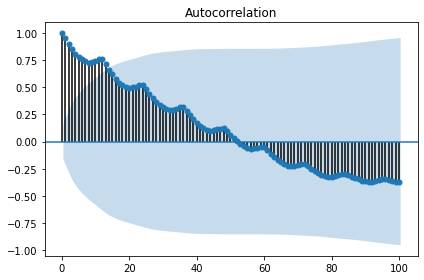

In [ ]:
### 로그 변환
display('Log transfer:')
plt.figure(figsize=(12,8))
np.log(raw).plot(ax=plt.subplot(222), title='log(Y)', legend=False)
plt.show()

candidate_trend = np.log(raw).copy()
display(stationary_adf_test(candidate_trend.values.flatten(), []))
display(stationary_kpss_test(candidate_trend.values.flatten(), []))
sm.graphics.tsa.plot_acf(candidate_trend, lags=100, use_vlines=True)
plt.tight_layout()
plt.show()

In [ ]:
# 로그 + 추세차분 변환
trend_diff_order_inital=0
result=stationary_adf_test(candidate_trend.values.flatten(), []).T # (-1,1) shape으로 만들어주기 위해 Transpose

if result['p-value'].values.flatten() < 0.1:
    trend_diff_order=trend_diff_order_inital
else:
    trend_diff_order=trend_diff_order_inital+1
print('Tred Difference', trend_diff_order)

Tred Difference 1


'Log and trend difference transfer'

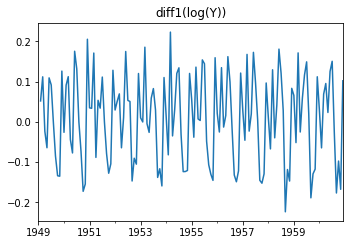

,Stationarity_adf
Test Statistics,-2.717131
p-value,0.071121
Used Lag,14.000000
Used Observations,128.000000
Critical Value(1%),-3.482501
Maximum information Criteria,-440.358470


,Stationarity_kpss
Test Statistics,0.101545
p-value,0.100000
Used Lag,14.000000
Critical Value(10%),0.347000


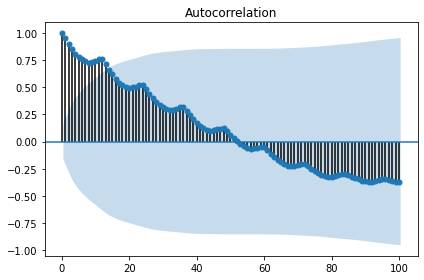

In [ ]:
# 로그 + 추세차분 변환
display('Log and trend difference transfer')
plt.figure(figsize=(12,8))
np.log(raw).diff(trend_diff_order).plot(ax=plt.subplot(224), title='diff1(log(Y))', legend=False)
plt.show()

candidate_seasonal=candidate_trend.diff(trend_diff_order).dropna().copy()

display(stationary_adf_test(candidate_seasonal.values.flatten(), []))
display(stationary_kpss_test(candidate_seasonal.values.flatten(), []))

sm.graphics.tsa.plot_acf(candidate_trend, lags=100, use_vlines=True)
plt.tight_layout()
plt.show()

In [ ]:
seasonal_diff_order = sm.tsa.acf(candidate_seasonal)[1:].argmax() + 1
print('Seasonal Difference: ', seasonal_diff_order)

Seasonal Difference:  12


'Log and trend+seasonal diffrence transfer:'

,Stationarity_adf
Test Statistics,-4.443325
p-value,0.000249
Used Lag,12.000000
Used Observations,118.000000
Critical Value(1%),-3.487022
Maximum information Criteria,-415.559753


,Stationarity_kpss
Test Statistics,0.108825
p-value,0.100000
Used Lag,13.000000
Critical Value(10%),0.347000


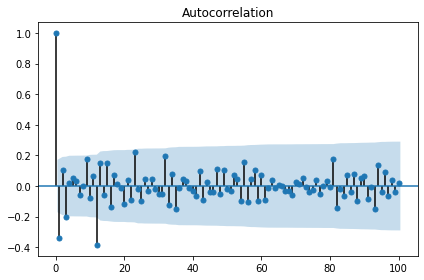

In [ ]:
### 로그+추세차분+계절차분 변환
display('Log and trend+seasonal diffrence transfer:')
candidate_final = candidate_seasonal.diff(seasonal_diff_order).dropna().copy()
display(stationary_adf_test(candidate_final.values.flatten(), []))
display(stationary_kpss_test(candidate_final.values.flatten(), []))
sm.graphics.tsa.plot_acf(candidate_final, lags=100, use_vlines=True)
plt.tight_layout()
plt.show()

일반 선형확률과정 (General Linear Process)
--

- 시계열 데이터가 가우시안 백색잡음의 현재값과 과거값의 선형조합

- 세부 알고리즘:

1) WN(White Noise)

2) MA(Moving Average)

3) AR(Auto-Regressive)

4) ARMA(Auto-Regressive Moving Average)

5) ARIMA(Auto-Regressive Integrated Moving Average)

6) SARIMA(Seasonal ARIMA)

첫 번째 예시: 가우시안 백색잡음

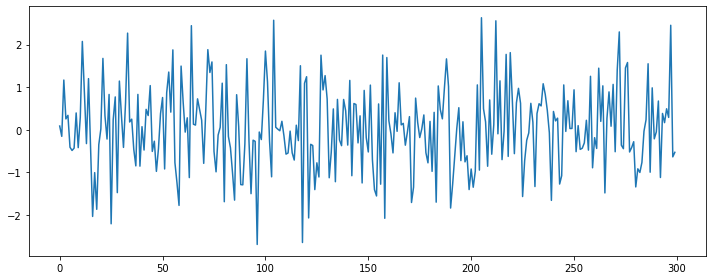

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(stats.norm.rvs(size=300)) # 임의로 잡음을 넣어줌
plt.tight_layout()
plt.show()

두 번째 예시: 베르누이 백색잡음 (0 or 1)

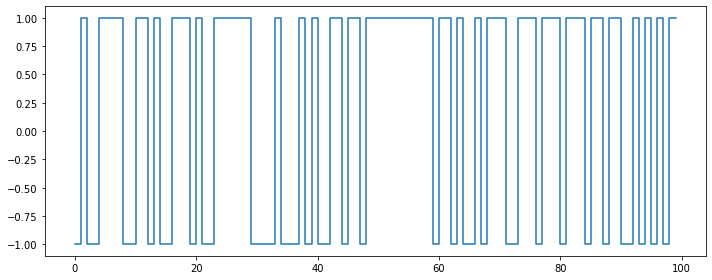

In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
samples = stats.bernoulli.rvs(0.5, size=100) * 2 - 1
plt.step(np.arange(len(samples)), samples)
plt.ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()

MA(Moving Average): 알고리즘 차수(q)가 유한한 가우시안 백색잡음과정의 선형조합

- Exponential Smoothing: 내 moving average smoothing은 과거의 trend-cycle을 추정하기 위함이고, MA는 미래 값을 예측하기 위함.

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

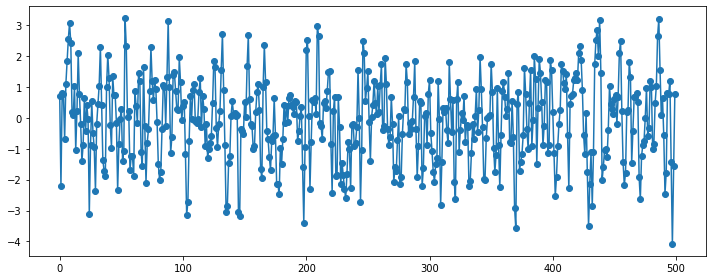

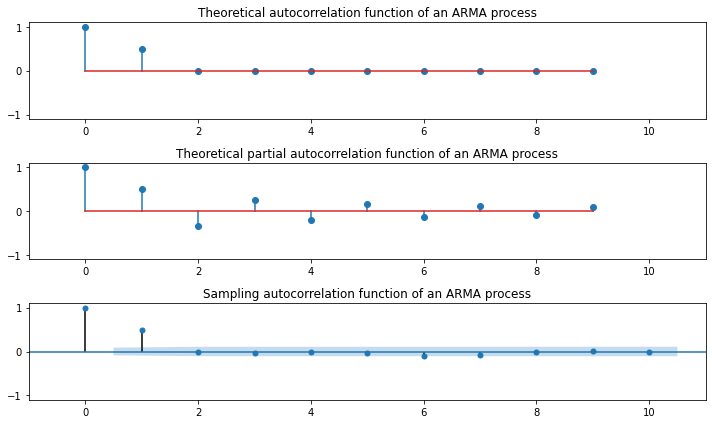

In [ ]:
### MA(1)
plt.figure(figsize=(10, 4))
np.random.seed(123)
ar_params = np.array([])
ma_params = np.array([0.9])
ar, ma = np.r_[1, -ar_params], np.r_[1, ma_params]
y = sm.tsa.ArmaProcess(ar, ma).generate_sample(500, burnin=50)
plt.plot(y, 'o-')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.stem(sm.tsa.ArmaProcess(ar, ma).acf(lags=10))
plt.xlim(-1, 11)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical autocorrelation function of an ARMA process")

plt.subplot(312)
plt.stem(sm.tsa.ArmaProcess(ar, ma).pacf(lags=10))
plt.xlim(-1, 11)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical partial autocorrelation function of an ARMA process")

sm.graphics.tsa.plot_acf(y, lags=10, ax=plt.subplot(313))
plt.xlim(-1, 11)
plt.ylim(-1.1, 1.1)
plt.title("Sampling autocorrelation function of an ARMA process")
plt.tight_layout()
plt.show()

AR, MA
--

- 평균은 동일 시점에서 단순 평균이 많이 사용됨.

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

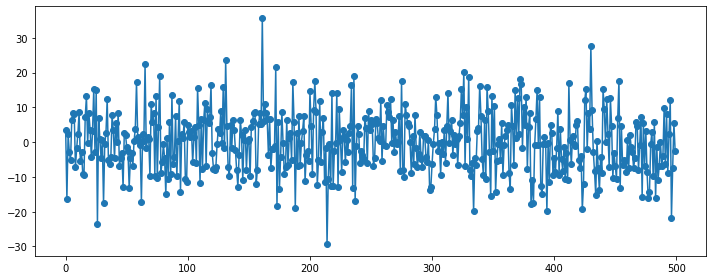

In [ ]:
### MA(1)
plt.figure(figsize=(10,4))
np.random.seed(42)
ar_params=np.array([])
ma_params=np.array([0,9]) #ma_params에 값을 부여
ar,ma=np.r_[1,-ar_params], np.r_[1,ma_params]

# np.r_: stack
# np.r_[a,b]: hstack: 왼쪽에서 오른쪽 붙이기/ merge()
# np.r_[[a],[b]]: 위에서 아래로 붙이기. merge(on='')
# np.c_[a,b]: columns stack / merge()

y=sm.tsa.ArmaProcess(ar, ma).generate_sample(500, burnin=50)
#burnin: Number of observation at the beginning of the sample to drop. Used to reduce dependence on initial values.

plt.plot(y, 'o-')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Theoretical autocorrelation function of an ARMA Process')

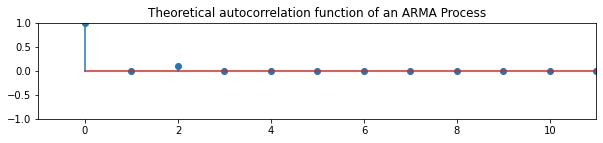

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(311)
plt.stem(sm.tsa.ArmaProcess(ar,ma).acf(lags=100))
plt.xlim(-1,11)
plt.ylim(-1,1,1,1)
plt.title('Theoretical autocorrelation function of an ARMA Process')

Text(0.5, 1.0, 'Theoretical partial autocorrelation function of an ARMA Process')

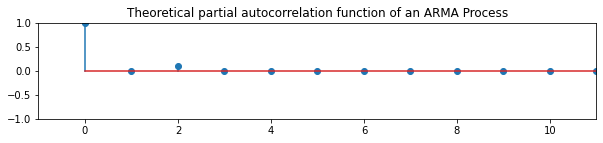

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(312)
plt.stem(sm.tsa.ArmaProcess(ar,ma).acf(lags=100))
plt.xlim(-1,11)
plt.ylim(-1,1,1,1)
plt.title('Theoretical partial autocorrelation function of an ARMA Process')

- 변동성이 작을 수록 좋음

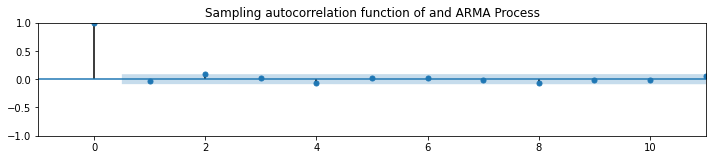

In [ ]:
plt.figure(figsize=(10,6))
sm.graphics.tsa.plot_acf(y, lags=100, ax=plt.subplot(313))
plt.xlim(-1,11)
plt.ylim(-1,1,1,1)
plt.title('Sampling autocorrelation function of and ARMA Process')
plt.tight_layout()
plt.show()

AR(Auto-Regressive)
--

다중 회귀 모델: 목표 예상 변수(forecast variable)의 선형조합을 이용하여 관심있는 변수를 예측

자기 회귀 모델: 변수의 과거값의 선형 조합을 이용하여 관심있는 변수를 선형 조합을 이용하여 관심 있는 변수를 예측, 자기 자신에 대한 변수의 회귀라는 의미.

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

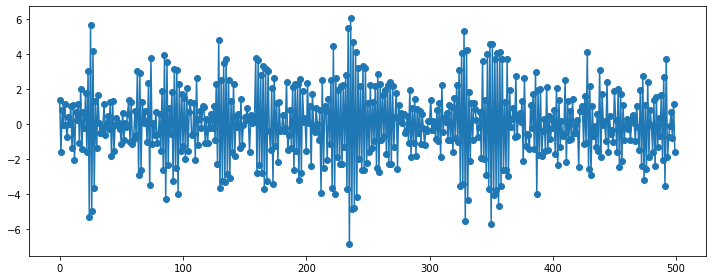

In [ ]:
### AR(1)
plt.figure(figsize=(10,4))
np.random.seed(42)
ar_params=np.array([-0.9]) # ar_params에 값을 부여
ma_params=np.array([])
ar,ma=np.r_[1,-ar_params], np.r_[1,ma_params]

# np.r_: stack
# np.r_[a,b]: hstack: 왼쪽에서 오른쪽 붙이기/ merge()
# np.r_[[a],[b]]: 위에서 아래로 붙이기. merge(on='')
# np.c_[a,b]: columns stack / merge()

y=sm.tsa.ArmaProcess(ar, ma).generate_sample(500, burnin=50)
#burnin: Number of observation at the beginning of the sample to drop. Used to reduce dependence on initial values.

plt.plot(y, 'o-')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Theoretical autocorrelation function of an ARMA Process')

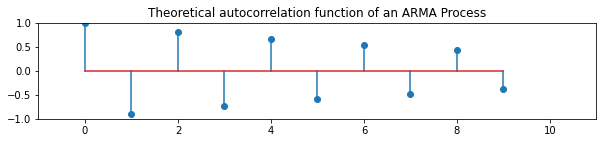

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(311)
plt.stem(sm.tsa.ArmaProcess(ar,ma).acf(lags=10))
plt.xlim(-1,11)
plt.ylim(-1,1,1,1)
plt.title('Theoretical autocorrelation function of an ARMA Process')

Text(0.5, 1.0, 'Theoretical partial autocorrelation function of an ARMA Process')

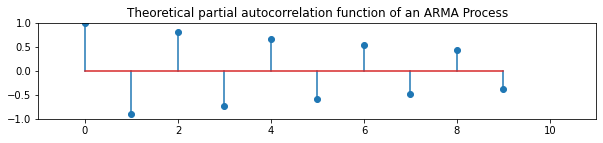

In [ ]:
plt.figure(figsize=(10,6))
plt.subplot(312)
plt.stem(sm.tsa.ArmaProcess(ar,ma).acf(lags=10))
plt.xlim(-1,11)
plt.ylim(-1,1,1,1)
plt.title('Theoretical partial autocorrelation function of an ARMA Process')

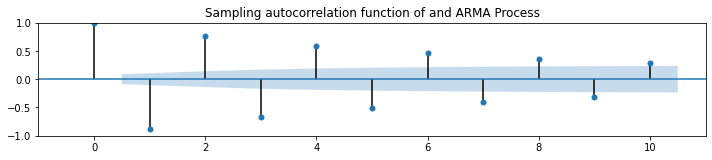

In [ ]:
plt.figure(figsize=(10,6))
sm.graphics.tsa.plot_acf(y, lags=10, ax=plt.subplot(313))
plt.xlim(-1,11)
plt.ylim(-1,1,1,1)
plt.title('Sampling autocorrelation function of and ARMA Process')
plt.tight_layout()
plt.show()

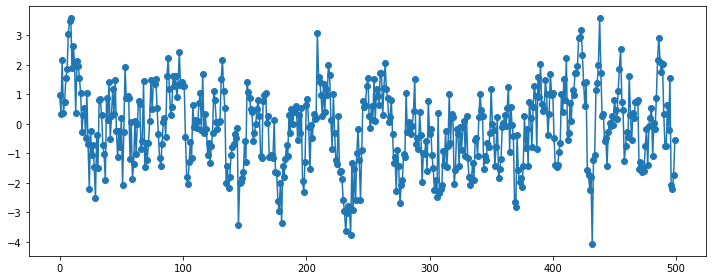

In [ ]:
### AR(2)
plt.figure(figsize=(10, 4))
np.random.seed(123)
ar_params = np.array([0.5, 0.25])
ma_params = np.array([])
ar, ma = np.r_[1, -ar_params], np.r_[1, ma_params]
y = sm.tsa.ArmaProcess(ar, ma).generate_sample(500, burnin=50)
plt.plot(y, 'o-')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Theoretical autocorrelation function of an ARMA process')

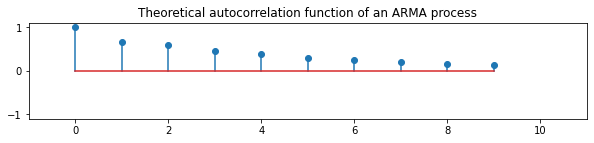

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(311)
plt.stem(sm.tsa.ArmaProcess(ar, ma).acf(lags=10))
plt.xlim(-1, 11)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical autocorrelation function of an ARMA process")

Text(0.5, 1.0, 'Theoretical partial autocorrelation function of an ARMA process')

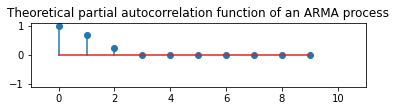

In [ ]:
plt.subplot(312)
plt.stem(sm.tsa.ArmaProcess(ar, ma).pacf(lags=10))
plt.xlim(-1, 11)
plt.ylim(-1.1, 1.1)
plt.title("Theoretical partial autocorrelation function of an ARMA process")

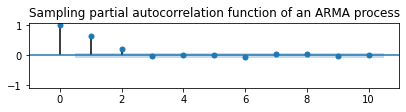

In [ ]:
sm.graphics.tsa.plot_pacf(y, lags=10, ax=plt.subplot(313))
plt.xlim(-1, 11)
plt.ylim(-1.1, 1.1)
plt.title("Sampling partial autocorrelation function of an ARMA process")
plt.tight_layout()
plt.show()

Relation of MA and AR
--

- 가역성 조건(Invertibility condition):

1) MA(q) -> AR(무한대): 변환 후 AR 모형이 Stationary Condition이면 "Invertibility" (가역성: 원래 상태로 돌아갈 수 있는 성격)

2) AR(p) -> MA(무한대): 여러개 모형변환 가능하지만, "Invertibility" 조건을 만족하는 MA 모형은 단 1개만 존재

과거 데이터가 뭐가 먼저 주어지냐에 따라서 다름. 과거로 가는 시점은 딱 1개만 존재, 과거에서 현재로 가는 시점은 여러 개 존재

ARMA(Auto-Regressive Moving Average)

ARMA(p, q): 알고리즘의 차수(p and q)가 유한한 AR(p)와 MA(q)의 선형조합

- AR과 MA의 정상성 조건과 가역성 조건이 동일하게 ARMA 알고리즘들에 적용

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels
import matplotlib.pyplot as plt

## ARMA(1,0) = AR(1)+MA(0)
# setting

np.random.seed(123)
ar_params=np.array([0.75])
ma_params=np.array([])

index_name=['const','ar(1)']
ahead=100
ar, ma=np.r_[1,-ar_params], np.r_[1,ma_params]
ar_order, ma_order=len(ar)-1, len(ma)-1

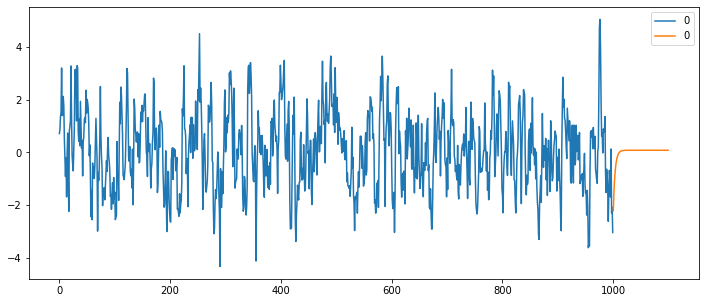

In [ ]:
# Generator
y=statsmodels.tsa.arima_process.arma_generate_sample(ar,ma, nsample=1000, burnin=5000)
fit=statsmodels.tsa.arima_model.ARMA(y, (ar_order, ma_order)).fit(trend='c', disp=0)

pred_ts_point=fit.forecast(steps= ahead)[0]
pred_ts_interval = fit.forecast(steps=ahead)[2]

ax=pd.DataFrame(y).plot(figsize=(12,5))
forecast_index=[i for i in range(pd.DataFrame(y).index.max()+1, pd.DataFrame(y).index.max()+ahead+1)]
pd.DataFrame(pred_ts_point, index=forecast_index).plot(label='forecast', ax=ax)

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
===================================================================
Model:              ARMA             BIC:                 2929.9736
Dependent Variable: y                Log-Likelihood:      -1454.6  
Date:               2021-06-28 06:54 Scale:               1.0000   
No. Observations:   1000             Method:              css-mle  
Df Model:           2                Sample:              0        
Df Residuals:       998                                   0        
Converged:          1.0000           S.D. of innovations: 1.036    
No. Iterations:     5.0000           HQIC:                2920.846 
AIC:                2915.2504                                      
---------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|     [0.025   0.975]
---------------------------------------------------------------------
const         0.1468     0.1349    1.0880   0.2768   -0.1176   0.4111
ar.L1.y       0.7579     0.0206   36.8558   0.0000    0.7176   0.7982
----------------------------------------------------------------------------
                Real           Imaginary          Modulus          Frequency
----------------------------------------------------------------------------
AR.1           1.3194             0.0000           1.3194             0.0000
===================================================================

"""

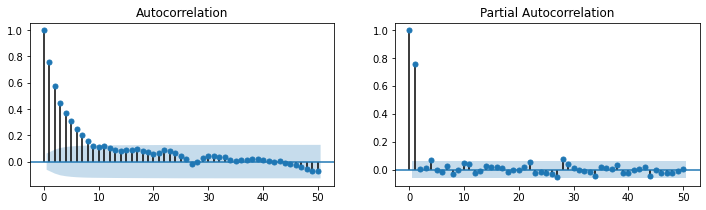

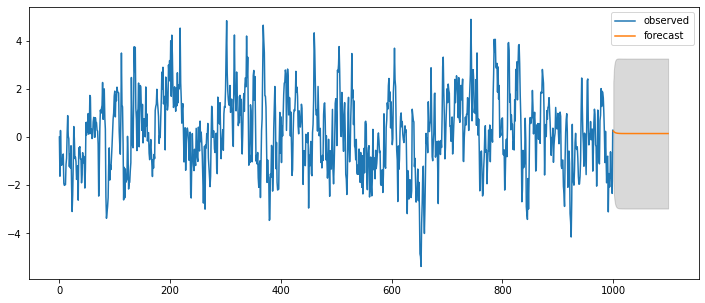

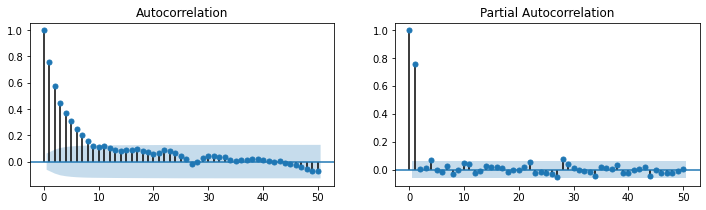

In [ ]:
# Generator
y = statsmodels.tsa.arima_process.arma_generate_sample(ar, ma, nsample=1000, burnin=500)
fit = statsmodels.tsa.arima_model.ARMA(y, (ar_order,ma_order)).fit(trend='c', disp=0)
pred_ts_point = fit.forecast(steps=ahead)[0]
pred_ts_interval = fit.forecast(steps=ahead)[2]
ax = pd.DataFrame(y).plot(figsize=(12,5))
forecast_index = [i for i in range(pd.DataFrame(y).index.max()+1, pd.DataFrame(y).index.max()+ahead+1)]
pd.DataFrame(pred_ts_point, index=forecast_index).plot(label='forecast', ax=ax)
ax.fill_between(pd.DataFrame(pred_ts_interval, index=forecast_index).index,
                pd.DataFrame(pred_ts_interval, index=forecast_index).iloc[:,0],
                pd.DataFrame(pred_ts_interval, index=forecast_index).iloc[:,1], color='k', alpha=0.15)
plt.legend(['observed', 'forecast'])
display(fit.summary2())
plt.figure(figsize=(12,3))
statsmodels.graphics.tsaplots.plot_acf(y, lags=50, zero=True, use_vlines=True, alpha=0.05, ax=plt.subplot(121))
statsmodels.graphics.tsaplots.plot_pacf(y, lags=50, zero=True, use_vlines=True, alpha=0.05, ax=plt.subplot(122))

20210629 수업
--

실습: 호흡기 질환 사망지수 ARMA 모델링

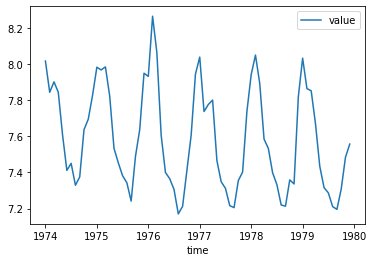

In [ ]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

#데이터 로딩 및 확인
data=sm.datasets.get_rdataset('deaths','MASS')
raw=data.data
raw.value=np.log(raw.value)
raw.plot(x='time', y='value')
plt.show()

Text(0.5, 1.0, 'PACF')

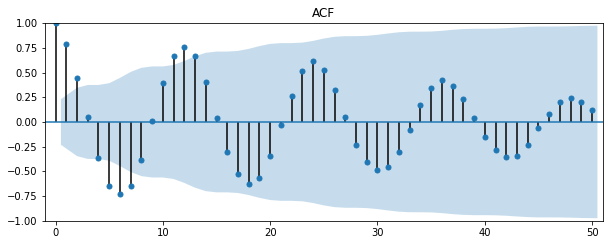

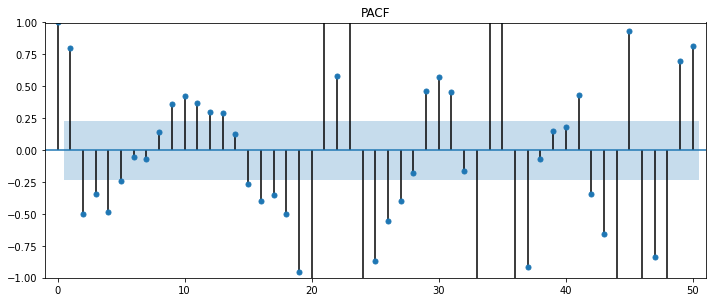

In [ ]:
# ACF/PACF 확인
plt.figure(figsize=(10,8))
sm.graphics.tsa.plot_acf(raw.value.values, lags=50, ax=plt.subplot(211))
plt.xlim(-1,51)
plt.ylim(-1,1,1,1)
plt.title('ACF')

# ACF/PACF 확인
plt.figure(figsize=(10,8))
sm.graphics.tsa.plot_pacf(raw.value.values, lags=50, ax=plt.subplot(212))
plt.xlim(-1,51)
plt.ylim(-1,1,1,1)
plt.tight_layout()
plt.title('PACF')

In [ ]:
#ARMA(1,1) 모델링
fit=sm.tsa.ARMA(raw.value, (1,1)).fit()
display(fit.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   72
Model:                     ARMA(1, 1)   Log Likelihood                  31.983
Method:                       css-mle   S.D. of innovations              0.154
Date:                Tue, 29 Jun 2021   AIC                            -55.965
Time:                        00:42:00   BIC                            -46.859
Sample:                             0   HQIC                           -52.340
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.6037      0.080     94.470      0.000       7.446       7.761
ar.L1.value     0.6796      0.098      6.970      0.000       0.489       0.871
ma.L1.value     0.4680      0.111      4.214      0.000       0.250       0.686
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4713           +0.0000j            1.4713            0.0000
MA.1           -2.1369           +0.0000j            2.1369            0.5000
-----------------------------------------------------------------------------
"""

,p,q,LLF,AIC,BIC
0,1,0,24.894297,-43.788594,-36.958595
1,1,1,31.982602,-55.965203,-46.858539
2,2,0,35.739122,-63.478243,-54.371579
3,2,1,44.512880,-79.025760,-67.642430
4,3,0,38.560200,-67.120400,-55.737069
5,3,1,45.279957,-78.559913,-64.899917


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  value   No. Observations:                   72
Model:                     ARMA(2, 1)   Log Likelihood                  44.513
Method:                       css-mle   S.D. of innovations              0.128
Date:                Tue, 29 Jun 2021   AIC                            -79.026
Time:                        01:14:42   BIC                            -67.642
Sample:                             0   HQIC                           -74.494
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           7.5920      0.020    384.993      0.000       7.553       7.631
ar.L1.value     1.6407      0.059     27.830      0.000       1.525       1.756
ar.L2.value    -0.8787      0.055    -16.027      0.000      -0.986      -0.771
ma.L1.value    -0.7021      0.075     -9.363      0.000      -0.849      -0.555
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9336           -0.5162j            1.0668           -0.0804
AR.2            0.9336           +0.5162j            1.0668            0.0804
MA.1            1.4243           +0.0000j            1.4243            0.0000
-----------------------------------------------------------------------------
"""

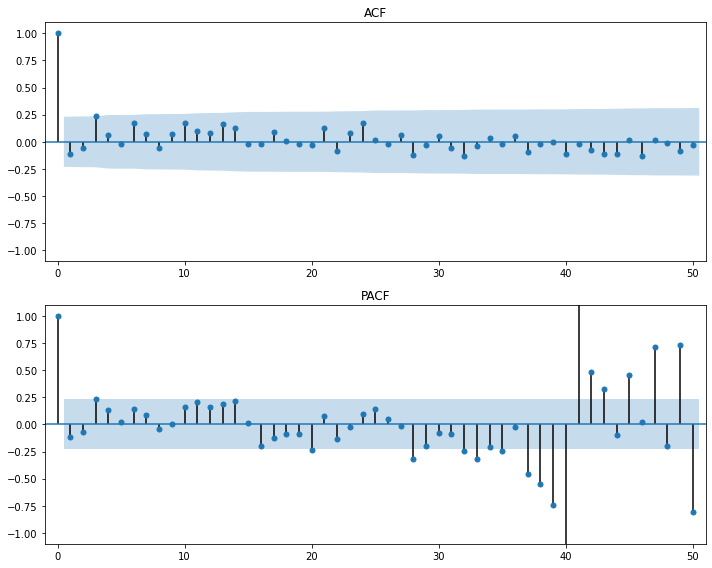

In [ ]:
from itertools import product
# 이제까지 p-value만 볼 수 있어서, p-value로 확인했다.
# 그치만, p-value가 0이고, p-value이외에도 확인할 수 있다면
#  P-value가 0이면 확인이 안 되서, ACF, PACF로 튀는 지점을
# 확인하는 작업을 할 수 있다.

# ARMA(p,q) 모델링
result = []
for p, q in product(range(4), range(2)):
    if (p == 0 & q == 0):
        continue
    model = sm.tsa.ARMA(raw.value, (p, q)).fit()
    try:
        result.append({"p": p, "q": q, "LLF": model.llf, "AIC": model.aic, "BIC": model.bic})
    except:
        pass
   
# 모형 최적모수 선택
result = pd.DataFrame(result)
display(result)
opt_ar = result.iloc[np.argmin(result['AIC']), 0]
opt_ma = result.iloc[np.argmin(result['AIC']), 1]

# ARMA 모델링
fit = sm.tsa.ARMA(raw.value, (opt_ar,opt_ma)).fit()
display(fit.summary())

# 잔차 ACF/PACF 확인
plt.figure(figsize=(10, 8))
sm.graphics.tsa.plot_acf(fit.resid, lags=50, ax=plt.subplot(211))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("ACF")

sm.graphics.tsa.plot_pacf(fit.resid, lags=50, ax=plt.subplot(212))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("PACF")
plt.tight_layout()
plt.show()

ARMAX(ARMA with eXogenous)
--

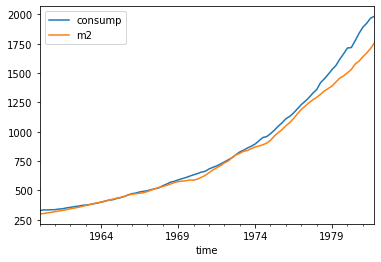

In [ ]:
import requests
from io import BytesIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# 데이터 로딩 및 확인
source_url = requests.get('http://www.stata-press.com/data/r12/friedman2.dta').content
raw = pd.read_stata(BytesIO(source_url))
raw.index = raw.time
raw_using = raw.loc['1960':'1981',["consump", "m2"]]
raw_using.plot()
plt.show()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                consump   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.721e+04
Date:                Tue, 29 Jun 2021   Prob (F-statistic):          7.72e-101
Time:                        01:19:48   Log-Likelihood:                -434.48
No. Observations:                  88   AIC:                             873.0
Df Residuals:                      86   BIC:                             877.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -61.7547      7.788     -7.930      0.000     -77.237     -46.273
m2             1.1406      0.009    131.182      0.000       1.123       1.158
==============================================================================
Omnibus:                        0.847   Durbin-Watson:                   0.094
Prob(Omnibus):                  0.655   Jarque-Bera (JB):                0.669
Skew:                           0.213   Prob(JB):                        0.716
Kurtosis:                       2.984   Cond. No.                     1.92e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

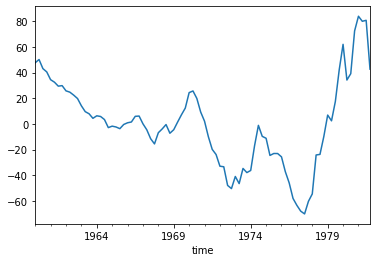

In [ ]:
# 모델링
## 회귀분석
fit = sm.OLS(raw_using.consump, sm.add_constant(raw_using.m2)).fit()
display(fit.summary())

## 잔차 확인
fit.resid.plot()
plt.show()

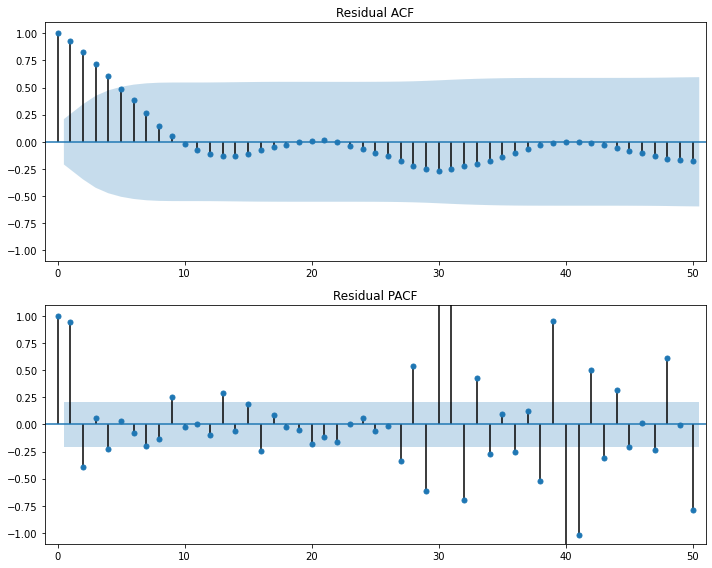

In [ ]:
## 잔차 ACF/PACF
plt.figure(figsize=(10, 8))
sm.graphics.tsa.plot_acf(fit.resid, lags=50, ax=plt.subplot(211))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual ACF")

sm.graphics.tsa.plot_pacf(fit.resid, lags=50, ax=plt.subplot(212))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual PACF")
plt.tight_layout()
plt.show()

In [ ]:
fit = sm.tsa.ARMA(raw_using.consump, (1,1), exog=raw_using.m2).fit()
display(fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                consump   No. Observations:                   88
Model:                     ARMA(1, 1)   Log Likelihood                -327.699
Method:                       css-mle   S.D. of innovations              9.873
Date:                Tue, 29 Jun 2021   AIC                            665.398
Time:                        01:34:49   BIC                            677.784
Sample:                    01-01-1960   HQIC                           670.388
                         - 10-01-1981                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -37.6132     36.043     -1.044      0.300    -108.256      33.030
m2                1.1232      0.034     33.282      0.000       1.057       1.189
ar.L1.consump     0.9330      0.043     21.866      0.000       0.849       1.017
ma.L1.consump     0.3106      0.116      2.682      0.009       0.084       0.538
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0718           +0.0000j            1.0718            0.0000
MA.1           -3.2199           +0.0000j            3.2199            0.5000
-----------------------------------------------------------------------------
"""

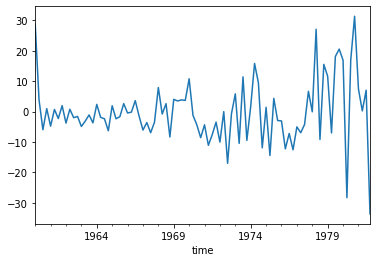

In [ ]:
## 잔차 확인
fit.resid.plot()
plt.show()

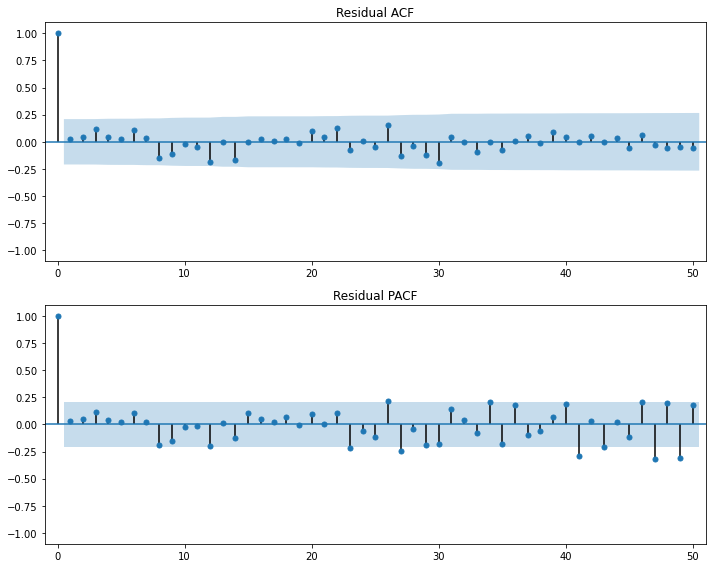

In [ ]:
## 잔차 ACF/PACF
plt.figure(figsize=(10, 8))
sm.graphics.tsa.plot_acf(fit.resid, lags=50, ax=plt.subplot(211))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual ACF")

sm.graphics.tsa.plot_pacf(fit.resid, lags=50, ax=plt.subplot(212))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual PACF")
plt.tight_layout()
plt.show()

ACF와 PACF를 확인해보면 ACF의 경우 신뢰구간이 매우 넓고 PACF같은경우 파란 범위를 벗어나는 값들이 매우 많다.

일반적으로는 binning, 이상치 제거, 스케일링 등등을 통해 이를 보완하지만,

ARMA에서는 이를 수정해주기 위해 계절성을 반영시킨다.

In [ ]:
# 모델링
# order: (p,d,q) p는 AR, q는 MA, d는 적분
# seasonal_oreder p는 AR q는 MA, d는 적분, s가 계절성

# SARIMAX 모델링
fit = sm.tsa.SARIMAX(raw_using.consump, exog=raw_using.m2, order=(1,0,0), seasonal_order=(1,0,1,4)).fit()
display(fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                           consump   No. Observations:                   88
Model:             SARIMAX(1, 0, 0)x(1, 0, 1, 4)   Log Likelihood                -333.579
Date:                           Tue, 29 Jun 2021   AIC                            677.158
Time:                                   01:35:36   BIC                            689.545
Sample:                               01-01-1960   HQIC                           682.148
                                    - 10-01-1981                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
m2             0.3645      0.140      2.605      0.009       0.090       0.639
ar.L1          0.9987      0.004    270.459      0.000       0.991       1.006
ar.S.L4        0.9541      0.060     15.848      0.000       0.836       1.072
ma.S.L4       -0.4736      0.159     -2.985      0.003      -0.785      -0.163
sigma2        95.1791      9.448     10.074      0.000      76.661     113.697
===================================================================================
Ljung-Box (Q):                       47.49   Jarque-Bera (JB):               229.53
Prob(Q):                              0.19   Prob(JB):                         0.00
Heteroskedasticity (H):              23.47   Skew:                            -0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- AIC, BIC가 이전에 비해 작아졌음

- 즉,모델이 더 안정적으로 변했음.

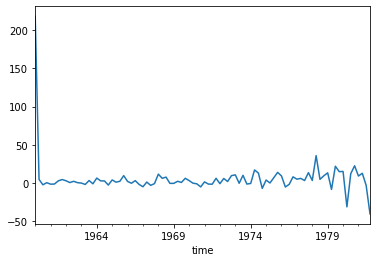

In [ ]:
# 잔차 확인
fit.resid.plot()
plt.show()

Text(0.5, 1.0, 'Residual ACF')

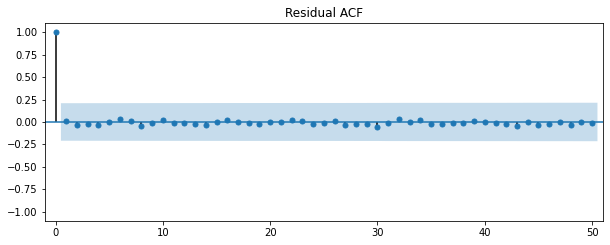

In [ ]:
# 잔차 ACF/PACF
plt.figure(figsize=(10, 8))
sm.graphics.tsa.plot_acf(fit.resid, lags=50, ax=plt.subplot(211))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual ACF")

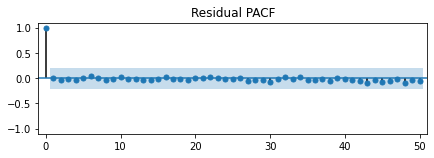

In [ ]:
sm.graphics.tsa.plot_pacf(fit.resid, lags=50, ax=plt.subplot(212))
plt.xlim(-1, 51)
plt.ylim(-1.1, 1.1)
plt.title("Residual PACF")
plt.tight_layout()
plt.show()

적분 선형확률과정(Integrated Linear Process)
--
ARIMA(Auto-Regressive Integrated Moving Average) 
--

ARIMA(p,d,q):1이상의 차분이 적용된 $\Delta^d Y_t = (1-L)^d Y_{t}$ 가 알고리즘의 차수(p~ and ~ q)가 유한한 AR(p)와 MA(q)의 선형조합

ARIMA(0,2,1)=IMA(2,1)

ARIMA 모델의 파라미터는 적절하게 구해야 함. -> 아니면 과적합을 일으킴

- ARIMA(0,0,0): 백색 잡음 모델

- ARIMA(0,1,0): 확률 보행, 0이 아닌 상수로 구성된 ARIMA(0,1,0)는 표류가 있는 확률 보행(Random walk with drift)

- ARIMA(0,1,1): 지수평활(exponential smoothing) 모델

- ARIMA(0,2,2): 지수평활을 추세를 가진 데이터로 확장 시킨 홀트의 선형 방법(Holt's linear method) (추세를 기반으로 한 예측이 사용 될 수 있음)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


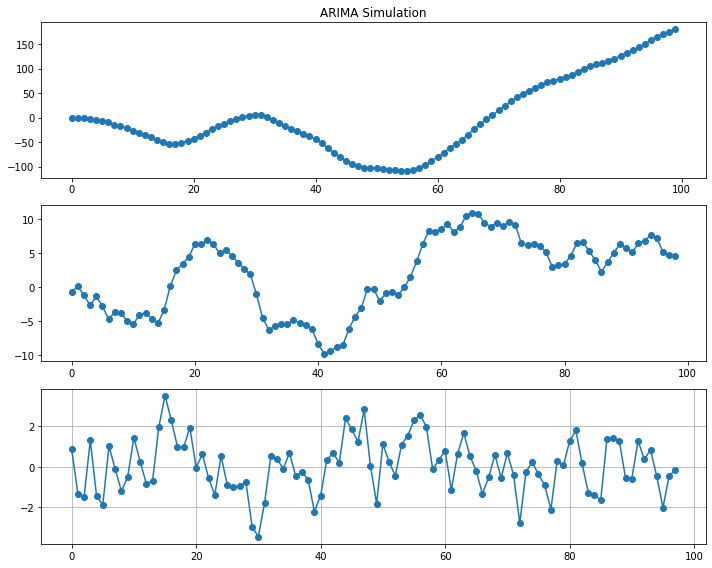

In [ ]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# 2차누적/1차누적/미누적 데이터생성 및 적분차수 이해
# cumsum(): 누적합

np.random.seed(123)
y2 = sm.tsa.ArmaProcess([1], [1, 0.6]).generate_sample(100).cumsum().cumsum()
y1 = np.diff(y2)
y0 = np.diff(y1)

plt.figure(figsize=(10,8))
plt.subplot(311)
plt.title("ARIMA Simulation")
plt.plot(y2, 'o-')
plt.subplot(312)
plt.plot(y1, 'o-')
plt.subplot(313)
plt.plot(y0, 'o-')
plt.tight_layout()
plt.grid()
plt.show()

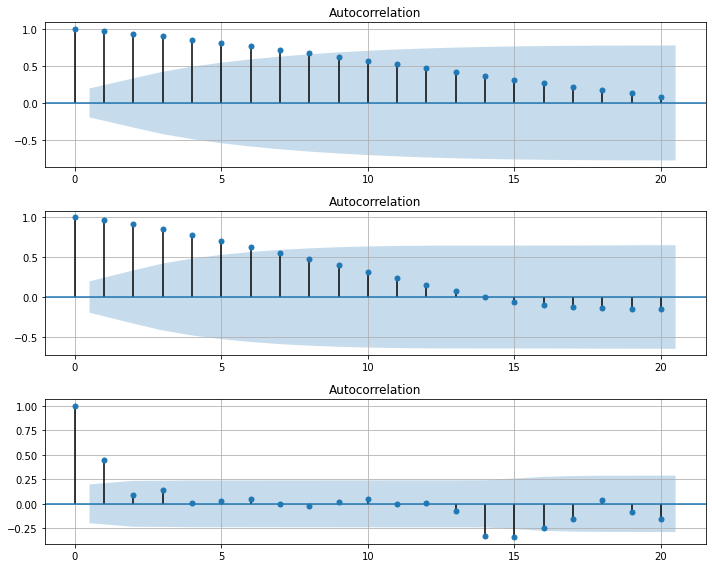

In [ ]:
# 2차누적/1차누적/미누적 데이터시각화
plt.figure(figsize=(10,8))
sm.tsa.graphics.plot_acf(y2, ax=plt.subplot(311))
plt.grid()
sm.tsa.graphics.plot_acf(y1, ax=plt.subplot(312))
plt.grid()
sm.tsa.graphics.plot_acf(y0, ax=plt.subplot(313))
plt.grid()
plt.tight_layout()
plt.show()


과적차분이란(Over-differencing):

- 필요 적분차수 이상의 차분은 MA 모형을 생성!

- ARIMA(0,d,0) -> $Y_t$를 d번 차분하면 백색잡음만 남음

- 과적합은 -> ACF/PACF의 수치를 오히려 증가시킬 수는 있음.

- 돋보기 역할 ( 미분을 더 해보면서 더 꼼꼼히 더 자세히 살펴보는 역할이다.)

- 그러나, 너무 많이 하면 좋지 않음. 따라서, 보통 2차 미분까지만 한다,

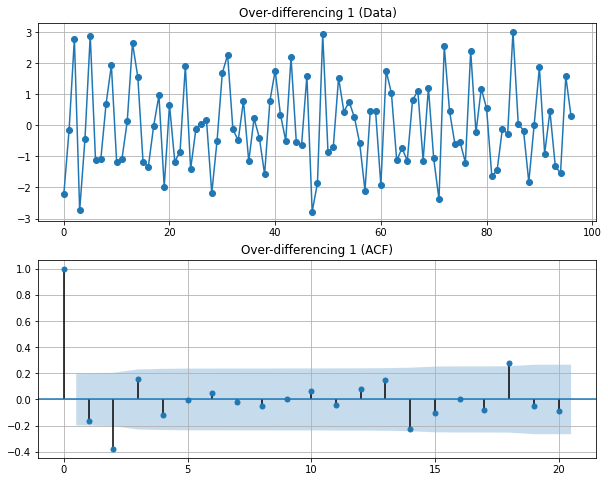

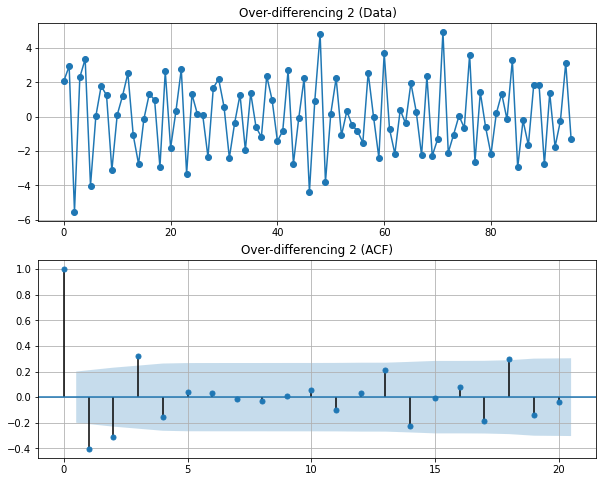

In [ ]:
# 과적차분 데이터 이해
# 의도적으로 잡음을 만들어줌?

y1_minus = np.diff(y0)

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(y1_minus, 'o-')
plt.title("Over-differencing 1 (Data)")
plt.grid()
sm.tsa.graphics.plot_acf(y1_minus, ax=plt.subplot(212))
plt.title("Over-differencing 1 (ACF)")
plt.grid()
plt.show()

y2_minus = np.diff(y1_minus)

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.plot(y2_minus, 'o-')
plt.title("Over-differencing 2 (Data)")
plt.grid()
sm.tsa.graphics.plot_acf(y2_minus, ax=plt.subplot(212))
plt.title("Over-differencing 2 (ACF)")
plt.grid()
plt.show()